In [1]:
%load_ext autoreload
%autoreload 2
 
import sys
sys.path.append('../src')
import xgboost as xgb
import pandas as pd
from features.UserJoin import UserJoin
from features.UserJoin import submit, diff, plt_month, plt_day, load_ids, info, infot
import config as C
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np


from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
from xgboost import plot_tree
import random
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import itertools
sns.set_style("ticks",{'axes.grid' : True})


/opt/conda/envs/miner/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
ds = UserJoin()

In [3]:
def filter(s, a, b):
    return (s >= a) & (s <= b)

# search 的结果

In [4]:
# 在29跑的结果
df = pd.read_csv('../src/test.csv')
df = df.groupby(['max_depth', 'n_estimators', 'learning_rate', 'colsample_bytree', 'subsample', 'gt']).first()
df = df[df.total != 0]
# t[t.right_miner > 28]
df['precision'] = df.right_miner / df.total
df = df.sort_values('precision', ascending=False)

# 粗略的看1200个模型的效果

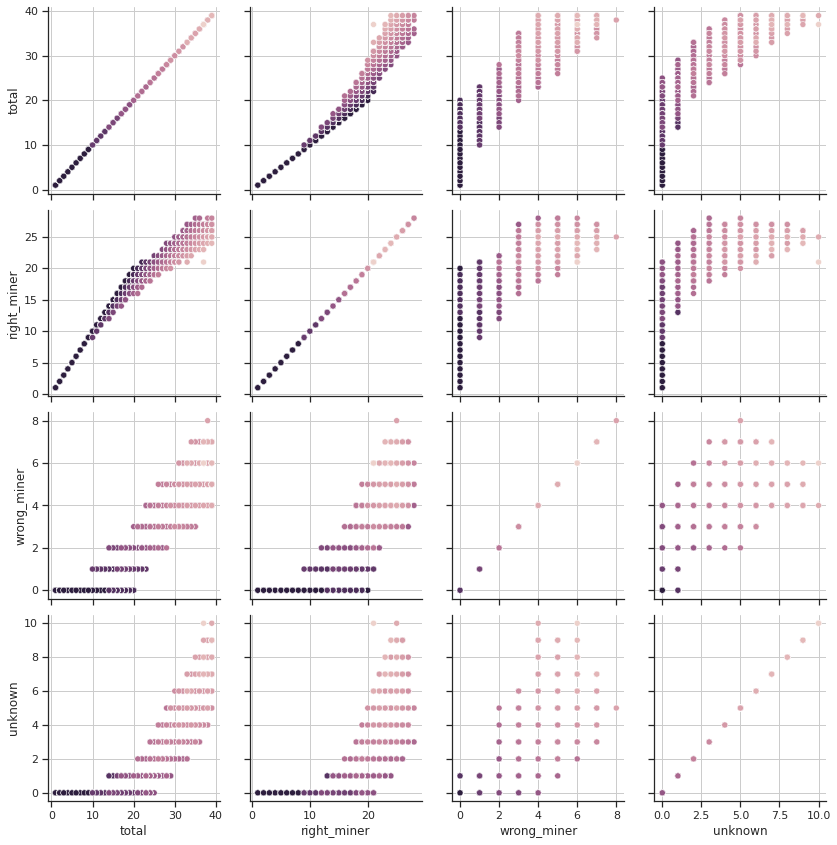

In [481]:
sns.set_style("ticks",{'axes.grid' : True})
g = sns.PairGrid(df[df.total < 40], height=3, hue='precision')
g.map(sns.scatterplot)

# 按预测的数量中对了的个数（没对的也分是错的，还是未知）

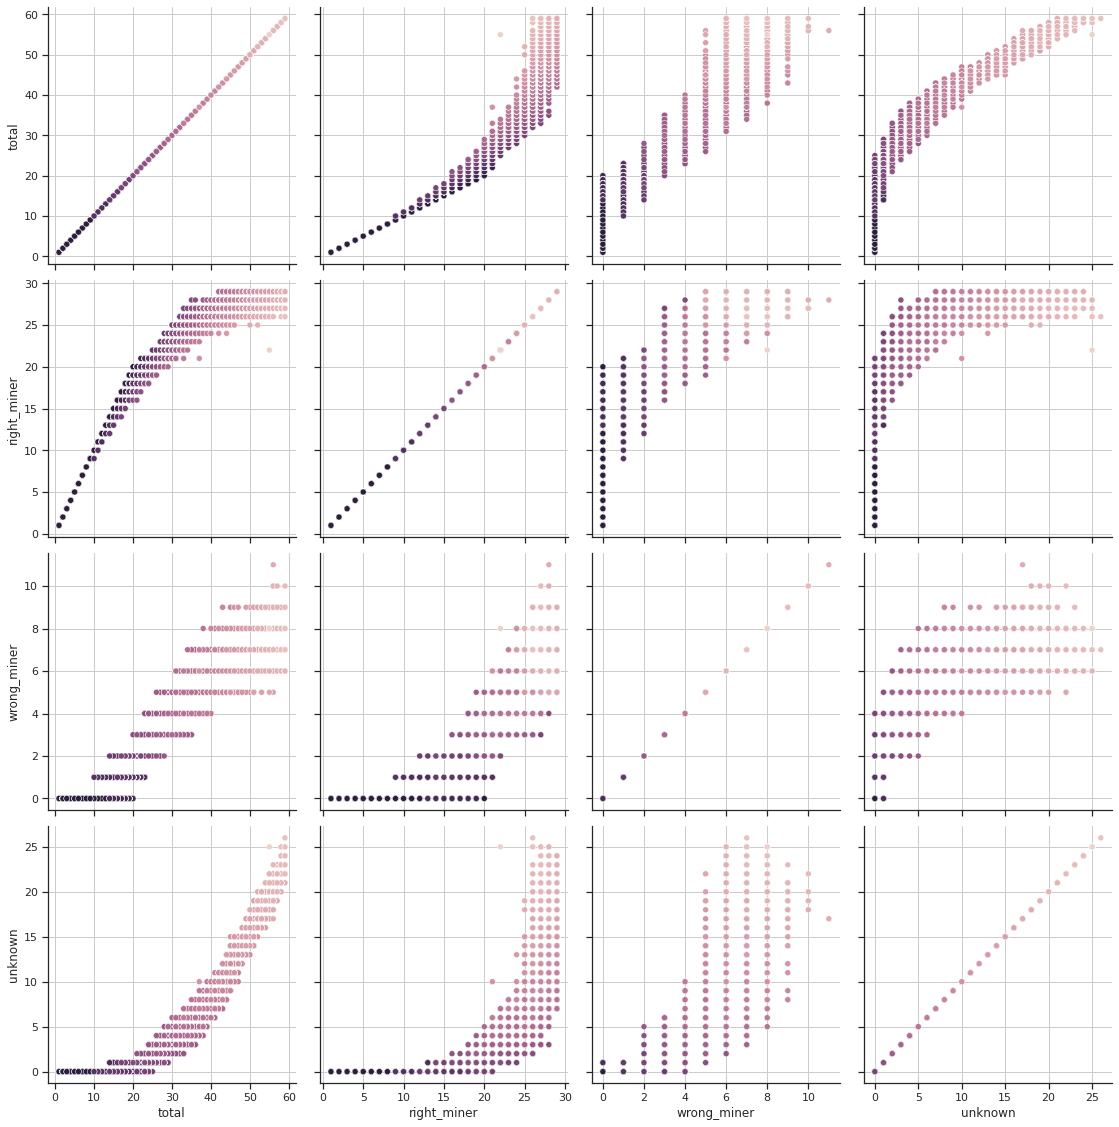

In [482]:
g = sns.PairGrid(df[df.total < 60], height=4, hue='precision')
g.map(sns.scatterplot)

## 过滤出预测结果中 25~30正确。 0~3错误的。
因为之前没保存模型，重新按照参数得到模型，拿到预测结果。然后看今天新发现的3个挖矿用户在不在里边。

In [5]:
t = df[filter(df.right_miner, 25, 37)  & filter(df.wrong_miner, 0, 3)]
t.sort_values('right_miner', ascending=False)

total  \
max_depth n_estimators learning_rate colsample_bytree subsample gt          
10        500          0.05          1.0              0.4       8      33   
8         100          0.10          0.8              0.4       8      33   
6         500          0.10          1.0              0.8       8      32   
10        300          0.10          0.4              0.8       8      32   
8         500          0.05          1.0              0.8       8      33   
...                                                                   ...   
6         500          0.05          0.3              0.8       8      31   
3         300          0.20          1.0              0.4       8      31   
8         300          0.10          0.6              0.4       8      31   
6         500          0.10          0.6              0.4       8      31   
3         300          0.20          0.3              0.4       7      34   

                                                                    right_miner  \
max_depth n_estimators learning_rate colsample_bytree subsample gt                
10        500          0.05          1.0              0.4       8            27   
8         100          0.10          0.8              0.4       8            27   
6         500          0.10          1.0              0.8       8            26   
10        300          0.10          0.4              0.8       8            26   
8         500          0.05          1.0              0.8       8            26   
...                                                                         ...   
6         500          0.05          0.3              0.8       8            25   
3         300          0.20          1.0              0.4       8            25   
8         300          0.10          0.6              0.4       8            25   
6         500          0.10          0.6              0.4       8            25   
3         300          0.20          0.3              0.4       7            25   

                                                                    wrong_miner  \
max_depth n_estimators learning_rate colsample_bytree subsample gt                
10        500          0.05          1.0              0.4       8             3   
8         100          0.10          0.8              0.4       8             3   
6         500          0.10          1.0              0.8       8             3   
10        300          0.10          0.4              0.8       8             3   
8         500          0.05          1.0              0.8       8             3   
...                                                                         ...   
6         500          0.05          0.3              0.8       8             3   
3         300          0.20          1.0              0.4       8             3   
8         300          0.10          0.6              0.4       8             3   
6         500          0.10          0.6              0.4       8             3   
3         300          0.20          0.3              0.4       7             3   

                                                                    unknown  \
max_depth n_estimators learning_rate colsample_bytree subsample gt            
10        500          0.05          1.0              0.4       8         3   
8         100          0.10          0.8              0.4       8         3   
6         500          0.10          1.0              0.8       8         3   
10        300          0.10          0.4              0.8       8         3   
8         500          0.05          1.0              0.8       8         4   
...                                                                     ...   
6         500          0.05          0.3              0.8       8         3   
3         300          0.20          1.0              0.4       8         3   
8         300          0.10          0.6              0.4       8         3   
6         500          0.10          

In [6]:
from IPython.display import display
for i in df.index.names:
    display(t.groupby(i).count()[['total']].T)


max_depth  3   5   6   8   10
total       4  18  29  24  19

n_estimators  100  200  300  500
total          21   13   22   38

learning_rate  0.01  0.05  0.10  0.20
total             9    43    31    11

colsample_bytree  0.3  0.4  0.6  0.8  1.0
total              11   12   15   22   34

subsample  0.4  0.8  1.0
total       63   24    7

gt     5  7   8  9
total  2  1  87  4

一些工具方法
* 按目前已知情报打 f1score
* 还原模型得到预测结果

In [7]:
from xgb_search import exp
from sklearn.metrics import f1_score

def f1score(ids):

    label = pd.DataFrame({
        'id': list(C.true_ids) + list(C.false_ids),
        'label': [1] * len(C.true_ids) + [0] * len(C.false_ids)
    }).set_index('id')
    join = label.join(pd.DataFrame({'id': list(ids), 'pred':1}).set_index('id')).fillna(0)
    return f1_score(join.label.values, join.pred.values, average='macro')
    
def predict_result(params):
    max_depth, n_estimators, learning_rate, colsample_bytree, subsample, gt = params
    p = {
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'colsample_bytree': colsample_bytree,
        'subsample': subsample,
    }
    pred_y, pred_val = exp(C.month_features, ds.month, p)

    ids = set(pred_val[pred_val.pred > gt].index.values)
    return ids

我还原了这部分模型然后看他们的结果，发现表现也一般。原先未知结果的几个预测，提交后发现对了一半错了一半。

In [11]:
preds = []
for i in tqdm(t[t.index.get_level_values('n_estimators') <= 200].index.values):
    preds.append(predict_result(i))

100%|██████████| 34/34 [03:13<00:00,  5.70s/it]


In [20]:
import pickle
pickle.dump(preds, open('month_preds.dump', 'wb'))

pickle.load(open('month_preds.dump', 'rb'))

[{179418058,
  179433516,
  179458306,
  179569820,
  362400993,
  855996491,
  1606708811,
  1912367373,
  1916407803,
  2071313507,
  2172970175,
  2186749200,
  2212416005,
  2238809293,
  2251440776,
  2256064355,
  2347718608,
  2347718610,
  2427050072,
  2445049876,
  2471562086,
  2479963778,
  2496032641,
  2523401557,
  2576321385,
  2602819207,
  2717225077,
  2741872006,
  2759232590,
  2817362052},
 {179418058,
  179433516,
  179458306,
  179569820,
  855996491,
  1606708811,
  1916407803,
  2071313507,
  2172970175,
  2186749200,
  2212416005,
  2238809293,
  2251440776,
  2256064355,
  2347718608,
  2347718610,
  2427050072,
  2445049876,
  2471562086,
  2479963778,
  2496032641,
  2523401557,
  2576321385,
  2602819207,
  2717225077,
  2741872006,
  2745781539,
  2759232590,
  2817362052,
  2852503463},
 {179418058,
  179433516,
  179458306,
  179569820,
  362400993,
  855996491,
  1606708811,
  1912367373,
  1916407803,
  2071313507,
  2172970175,
  2186749200,
  22124

In [21]:
for idx, i in enumerate(preds):
        print(idx, f'共预测 {len(i)} \t 一共对了 {len(i & C.true_ids)} \t \
            错的 {len(i & C.false_ids)} \t \
            未知的 {len(i - C.true_ids - C.false_ids)} \t f1score {f1score(i)}')
        # print(f1score(i))

0 共预测 30 	 一共对了 26 	             错的 4 	             未知的 0 	 f1score 0.8048552754435108
1 共预测 30 	 一共对了 26 	             错的 4 	             未知的 0 	 f1score 0.8048552754435108
2 共预测 33 	 一共对了 29 	             错的 4 	             未知的 0 	 f1score 0.8560606060606061
3 共预测 32 	 一共对了 28 	             错的 4 	             未知的 0 	 f1score 0.8389324960753533
4 共预测 32 	 一共对了 28 	             错的 4 	             未知的 0 	 f1score 0.8389324960753533
5 共预测 32 	 一共对了 28 	             错的 4 	             未知的 0 	 f1score 0.8389324960753533
6 共预测 32 	 一共对了 28 	             错的 4 	             未知的 0 	 f1score 0.8389324960753533
7 共预测 31 	 一共对了 27 	             错的 4 	             未知的 0 	 f1score 0.821875
8 共预测 31 	 一共对了 27 	             错的 4 	             未知的 0 	 f1score 0.821875
9 共预测 31 	 一共对了 27 	             错的 4 	             未知的 0 	 f1score 0.821875
10 共预测 31 	 一共对了 27 	             错的 4 	             未知的 0 	 f1score 0.821875
11 共预测 31 	 一共对了 27 	             错的 4 	             未知的 0 	 f1score 0.821875
12 共

看看这些对的和错的是不是在其他数据上会有区别。

In [492]:
from functools import reduce
pred_false_ids = []
for idx, i in enumerate(preds):
    pred_false_ids.append(i & C.false_ids)

inner = reduce(lambda a,b: a&b, pred_false_ids)
all = reduce(lambda a,b: a|b, pred_false_ids)
print(f'inner {inner}')
print(f'all {all}')

inner {2251440776, 179433516, 2602819207}
all {2479963778, 2602819207, 2251440776, 2784950026, 179433516, 179571678, 2115712219, 179569085, 2451165982}


In [ ]:
plt_day(inner, ds.day)

In [ ]:
plt_day(random.sample(C.true_ids | set(C.minerids), 12), ds.day, cols=C.day_origin)

In [494]:
plt_day(random.sample(C.true_ids | set(C.minerids), 12), ds.day[ds.day.type == 0], cols=C.day_origin)
plt_day(random.sample(C.true_ids | set(C.minerids), 12), ds.day[ds.day.type != 0], cols=C.day_origin)

[2482675592, 2471562086, 2654985038, 1998335717, 2674563661, 2172970175, 179418058, 2347718610, 2319973783, 2347718608, 855996491, 2256064355]


[2852503463, 2471562086, 2172970175, 2256064355, 2445049876, 2319973783, 2614556942, 362400993, 2238809293, 2817362052, 2212416005, 2825175309]


In [495]:
plt_day(inner, ds.day, cols=C.day_origin)

[2251440776, 179433516, 2602819207]


In [496]:
plt_day(inner, ds.day[ds.day.type == 0], cols=C.day_origin)

[2251440776, 179433516, 2602819207]


In [497]:
plt_day(inner, ds.day[ds.day.type != 0], cols=C.day_origin)

[2251440776, 179433516, 2602819207]


In [507]:
def rq_2_int(df):
    df['_rq'] = df.rq
    return df
    dct = {}
    for i, v in enumerate(df['_rq'].sort_values().unique()):
        dct[v] = i
    df = df.replace({'_rq': dct})
    return df

In [503]:
# def check_holiday(id):
#     tmp = ds.day[ds.day.index == id][['rq','kwh', 'type']].reset_index()
#     tmp = tmp[tmp.type != 2]
#     tmp = rq_2_int(tmp)
#     g = sns.relplot(
#         data=tmp,
#         x="_rq", y="kwh", col="type", hue="type",
#         kind="line", palette="crest", linewidth=3, zorder=5,
#         col_wrap=3, height=5, aspect=1.5, legend=False,
#     )
#     for type, ax in g.axes_dict.items():

#         # Add the title as an annotation within the plot
#         ax.text(.8, .85, type, transform=ax.transAxes, fontweight="bold")

#         # Plot every year's time series in the background
#         sns.lineplot(
#             data=tmp, x="_rq", y="kwh", units="type",
#             estimator=None, color=".7", linewidth=1, ax=ax,
#         )

#     # Reduce the frequency of the x axis ticks
#     ax.set_xticks(ax.get_xticks()[::2])

#     # Tweak the supporting aspects of the plot
#     g.set_titles("")
#     g.set_axis_labels("", "kwh")
#     g.tight_layout()

In [521]:
def check_holiday2(id, ax, col='kwh_pap_r4'):
    sns.set(rc={'figure.figsize':(24, 5)})
    tmp = ds.day[ds.day.index == id][['rq',col, 'type']].reset_index()
    tmp = tmp[tmp.type != 2]
    tmp = rq_2_int(tmp)
    # tmp[f'{col}2'] = tmp[col] / tmp[col].max()
    tmp[f'{col}2'] = tmp[col]
    ax.set(ylim=(0, tmp[col].max()))
    sns.scatterplot(data=tmp, x="_rq", y=f'{col}2', hue="type", ax=ax, palette='pastel' if id in C.false_ids else 'hls')

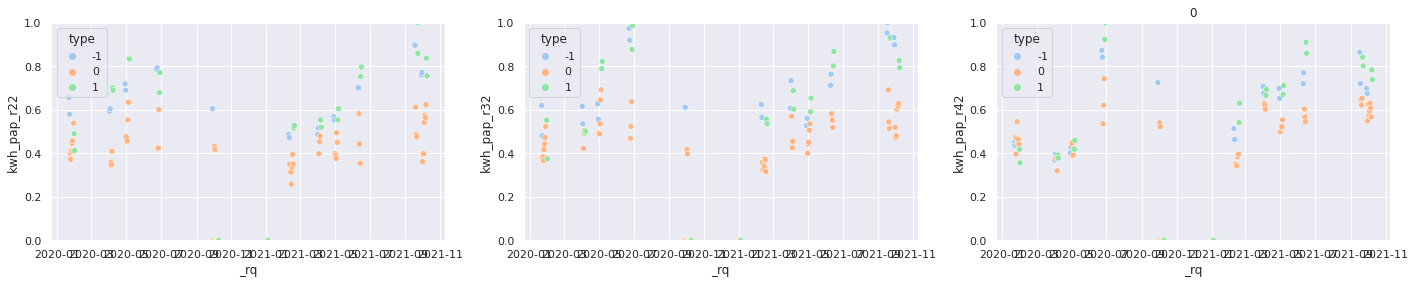

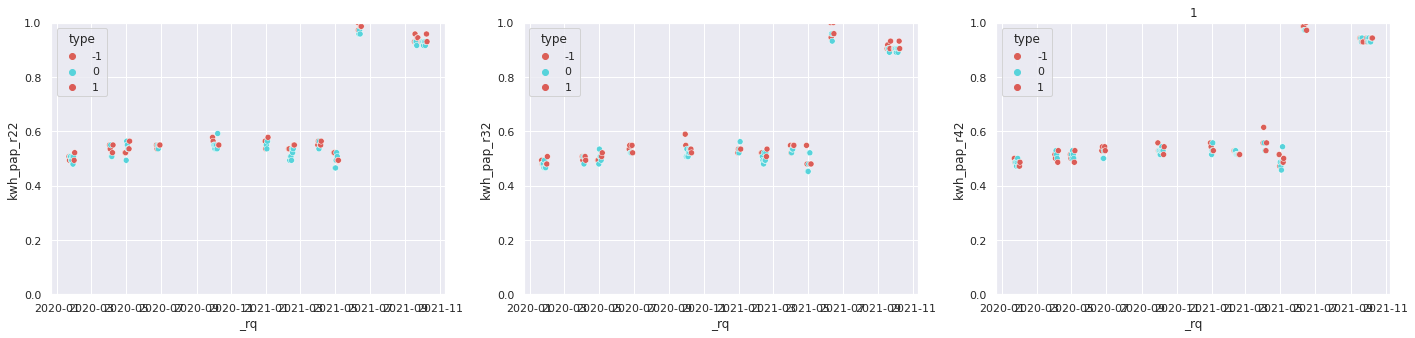

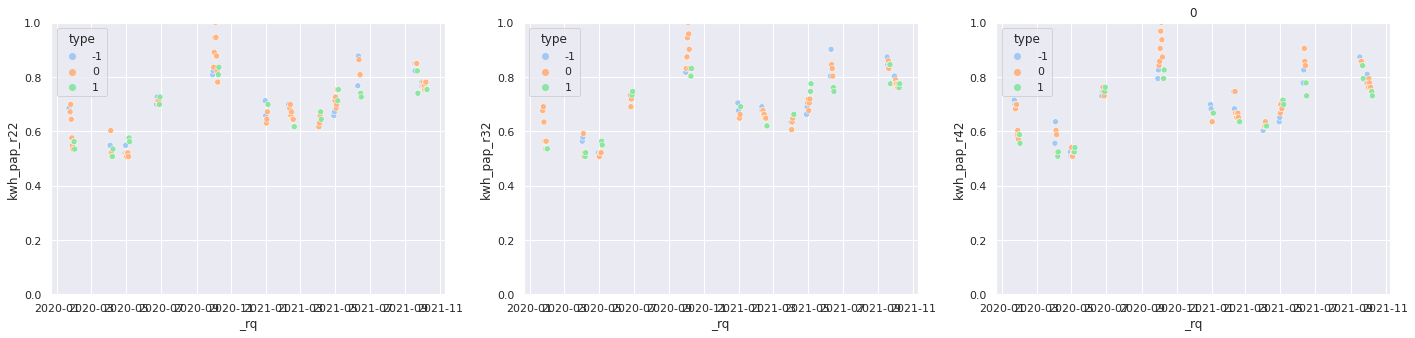

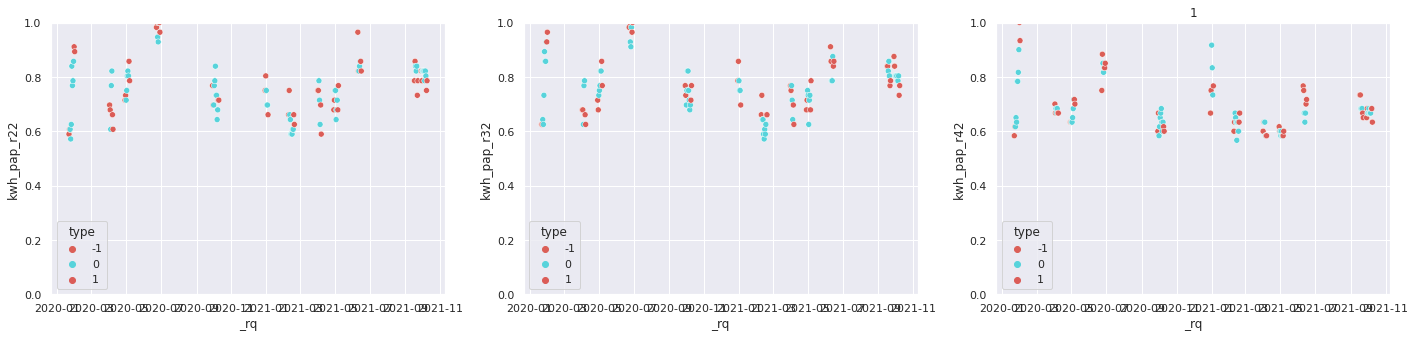

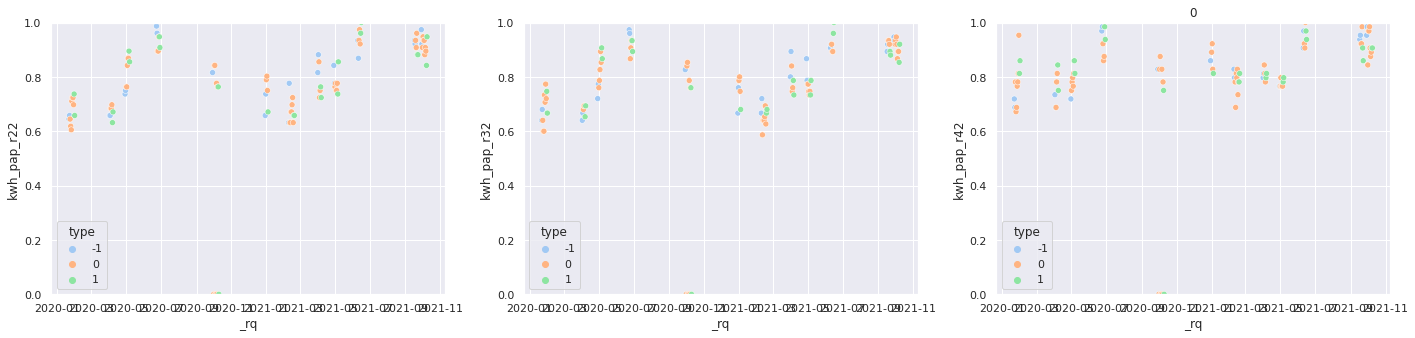

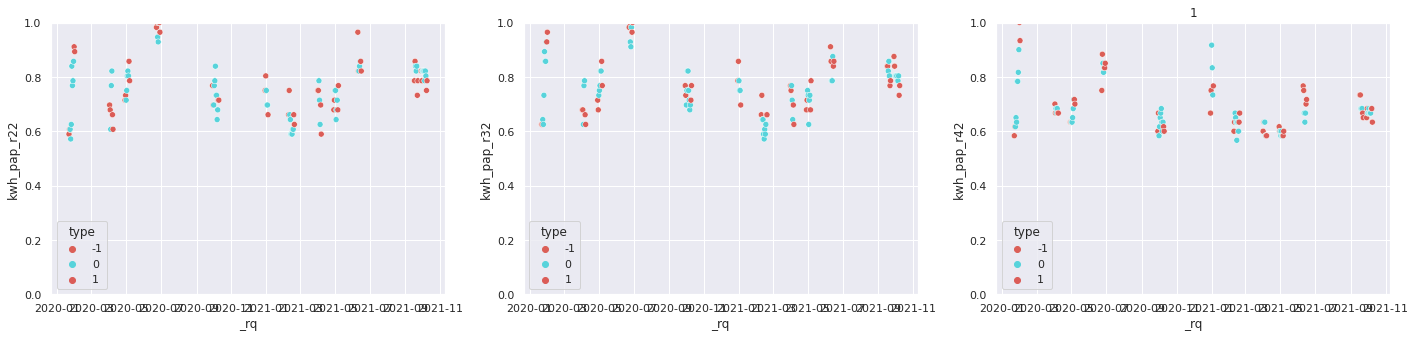

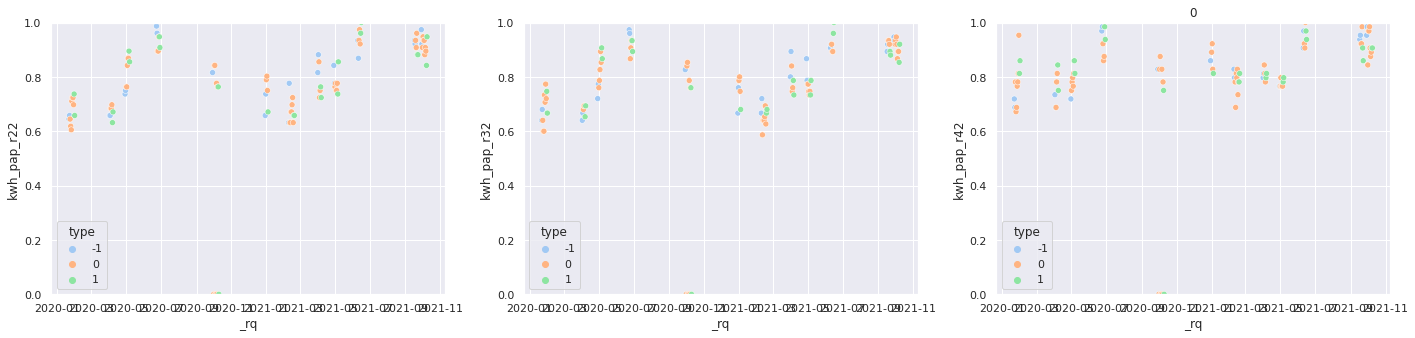

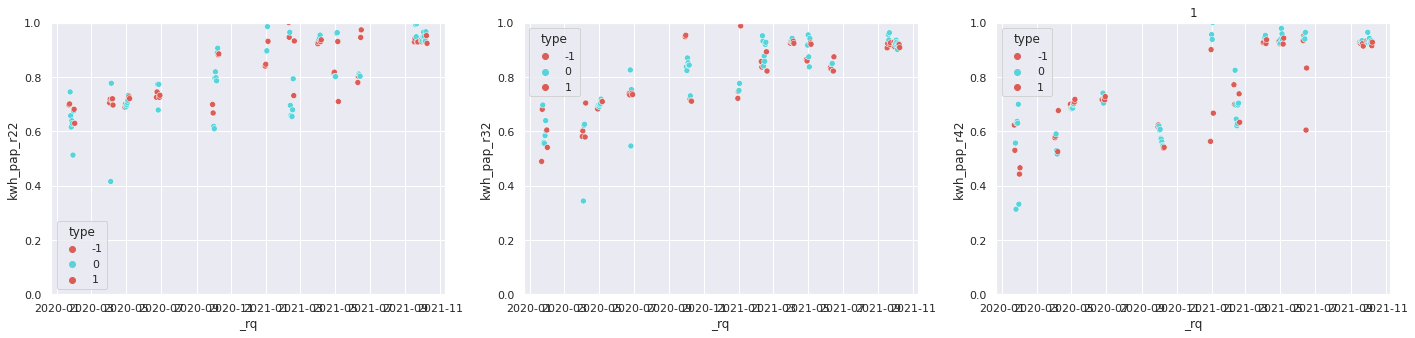

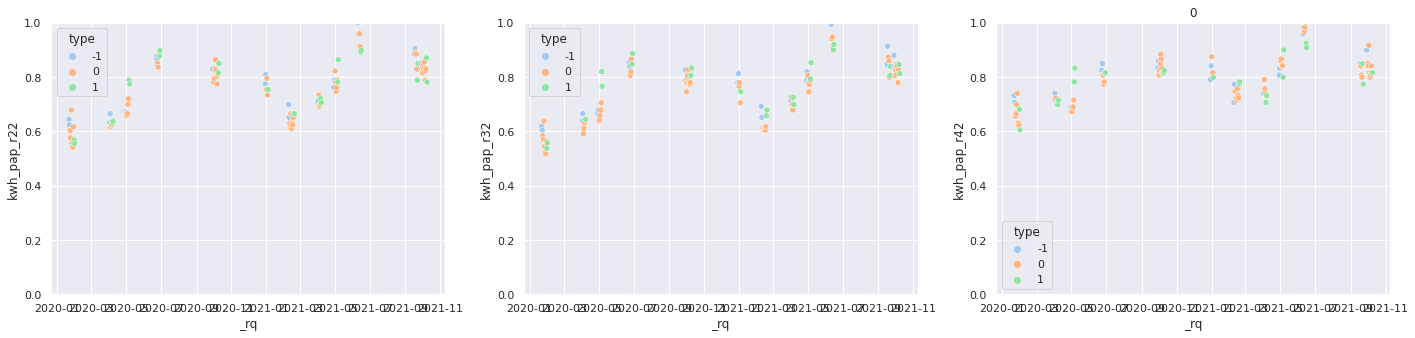

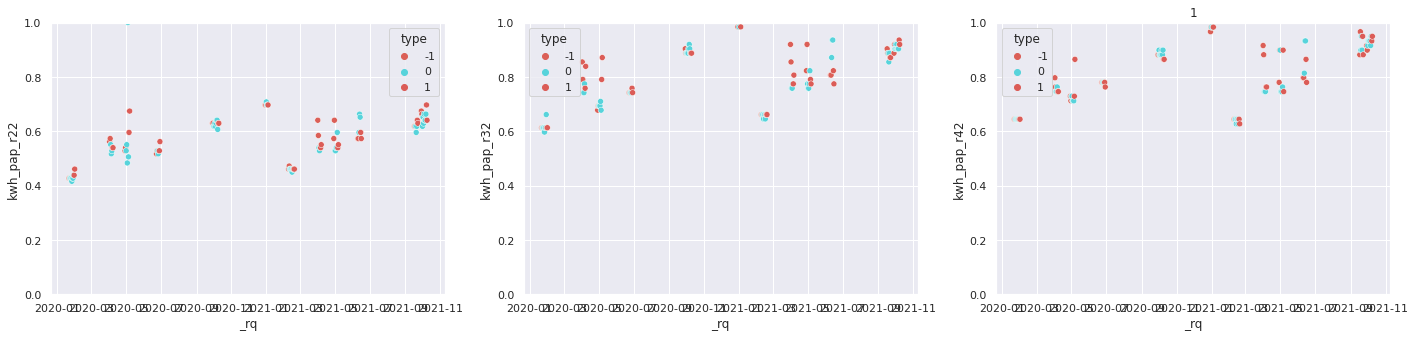

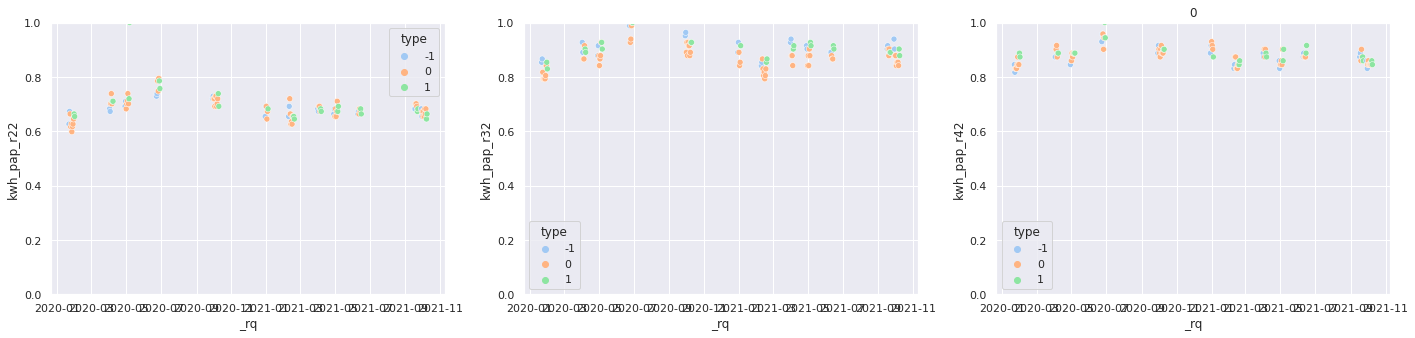

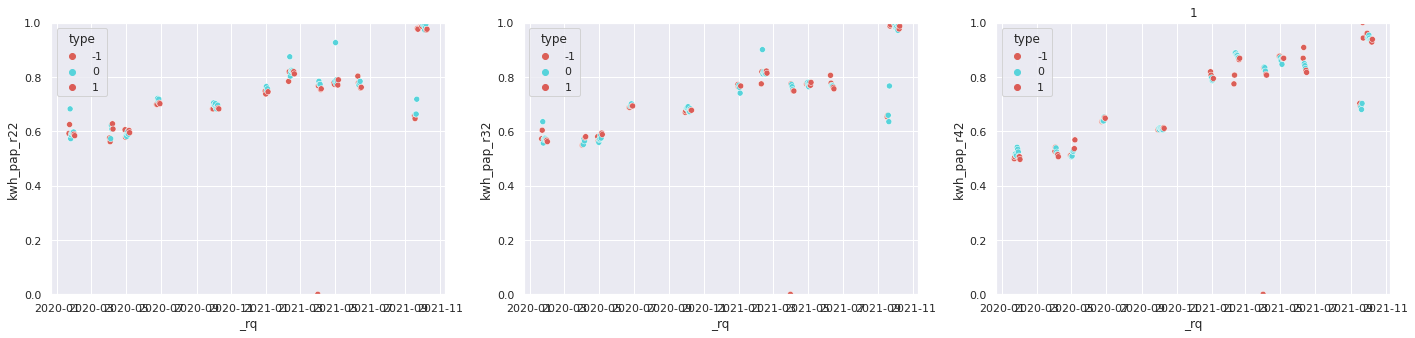

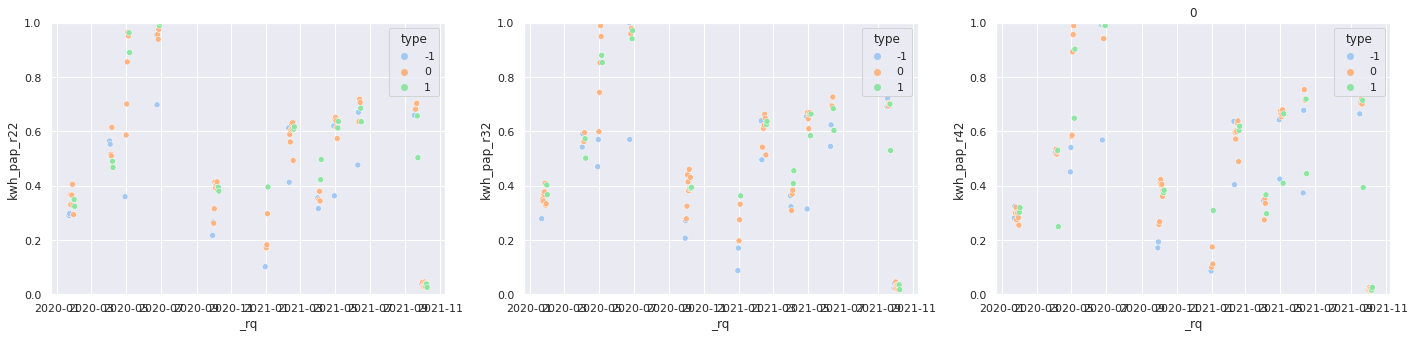

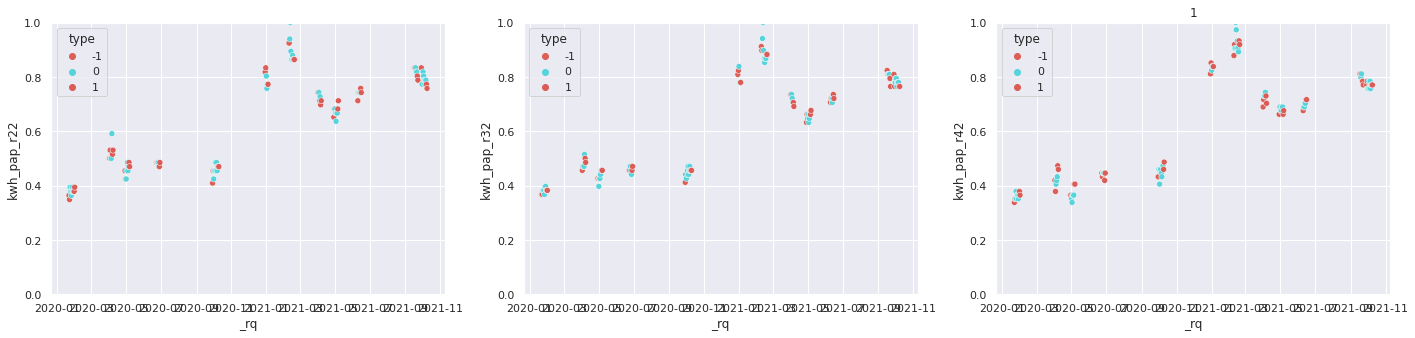

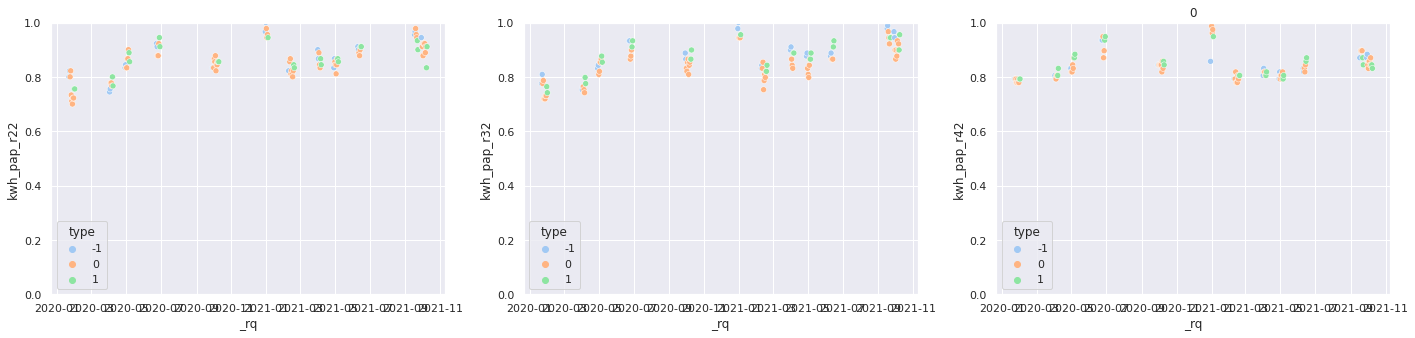

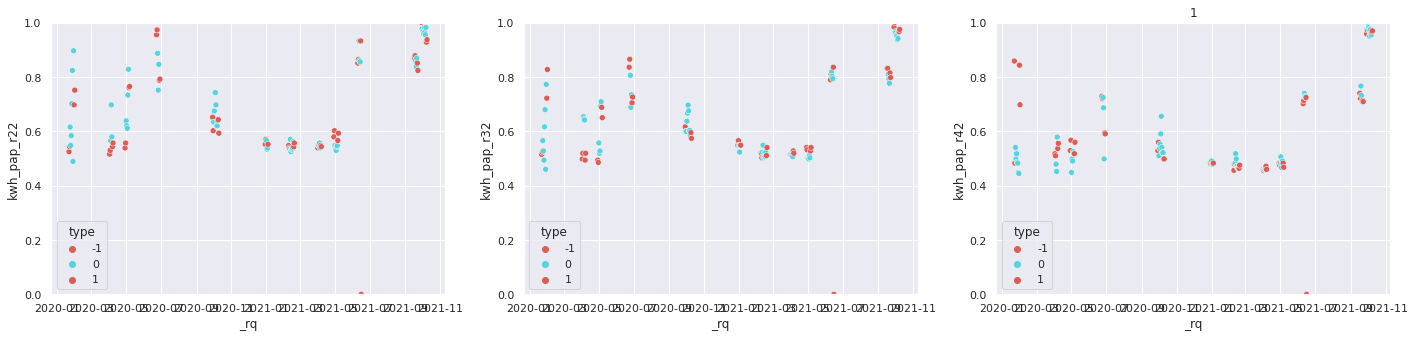

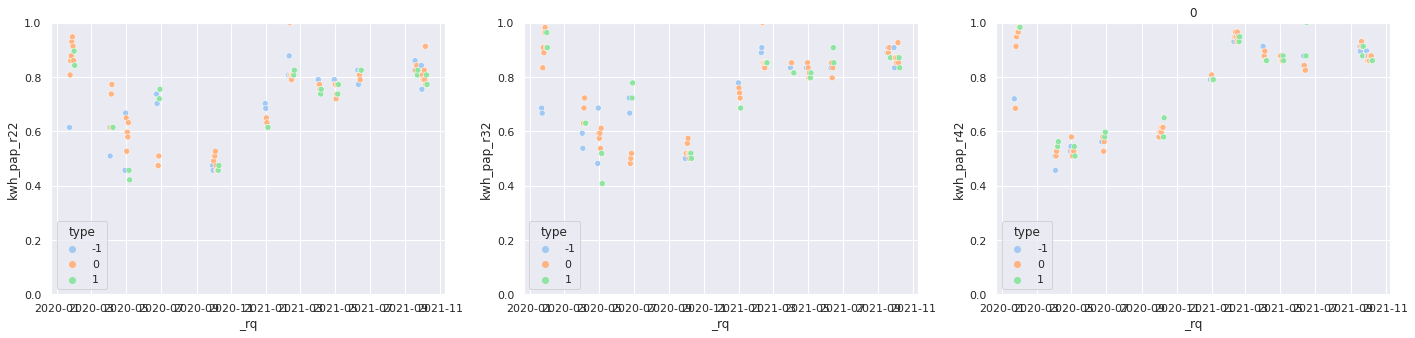

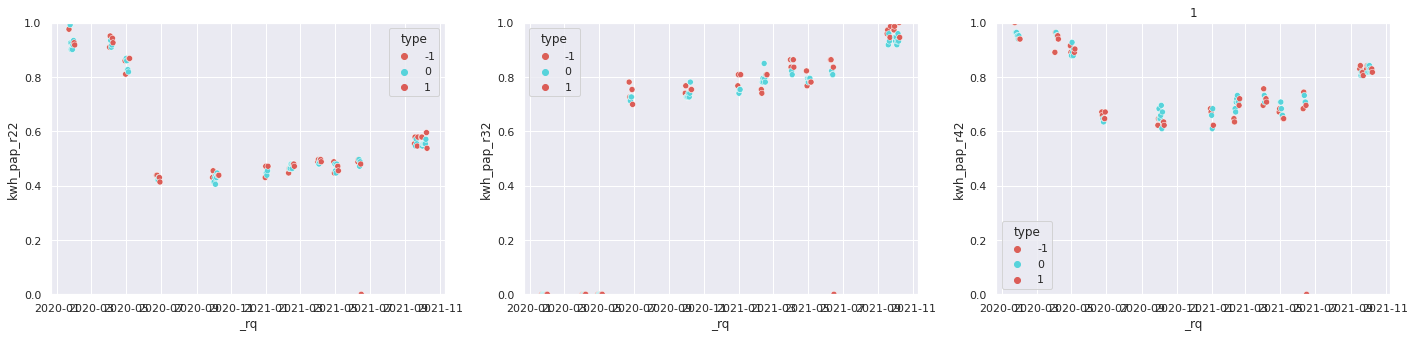

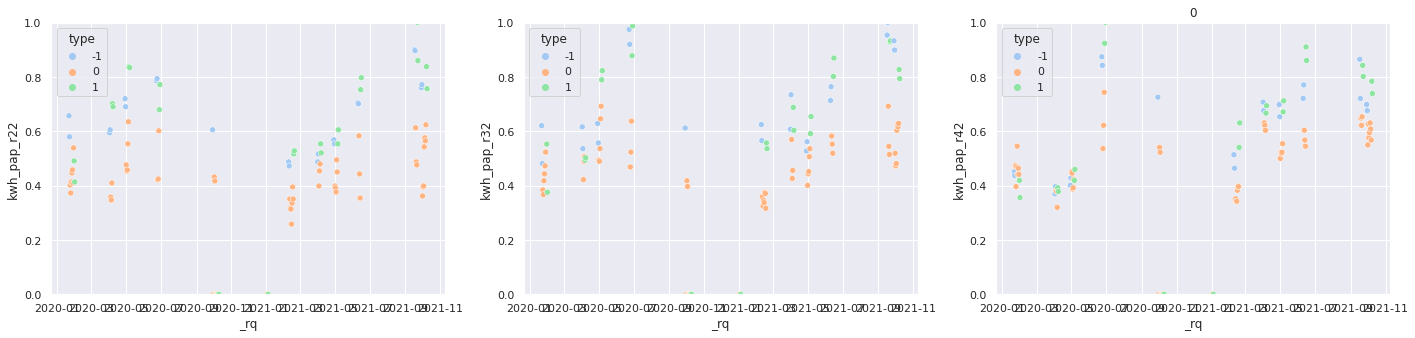

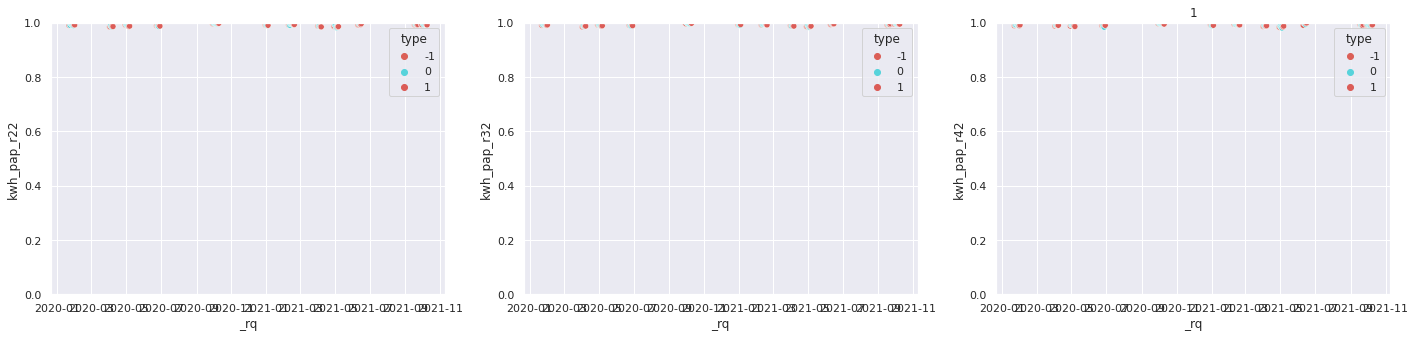

In [512]:
def plt_holiday(id, title):
    fig, axs = plt.subplots(ncols=3)
    check_holiday2(id, axs[0], col='kwh_pap_r2')
    check_holiday2(id, axs[1], col='kwh_pap_r3')
    check_holiday2(id, axs[2], col='kwh_pap_r4')
    plt.title(title)
    fig.show()

# plt_holiday(list(inner)[2], 'inner')
for i in range(10):
    plt_holiday(random.sample(C.false_ids, 1)[0], '0')
    plt_holiday(random.sample(C.true_ids | set(C.minerids), 1)[0], '1')

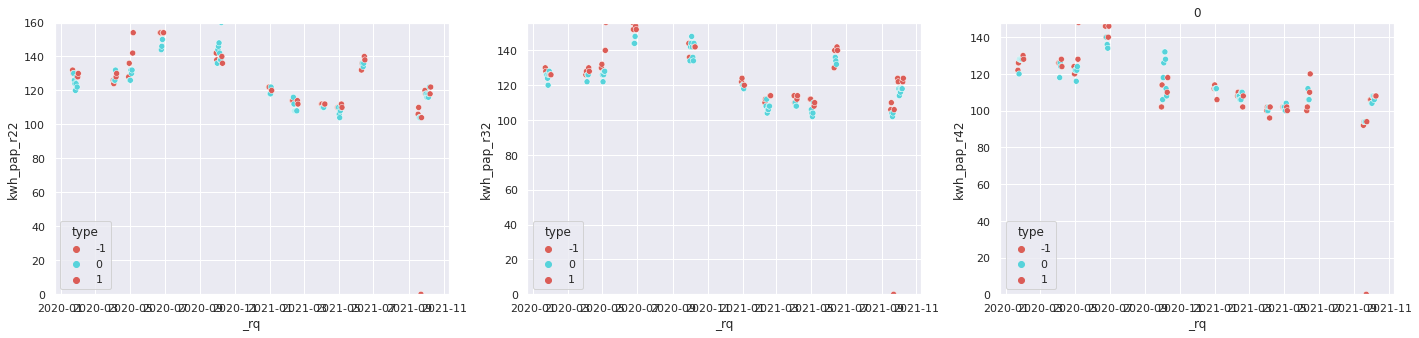

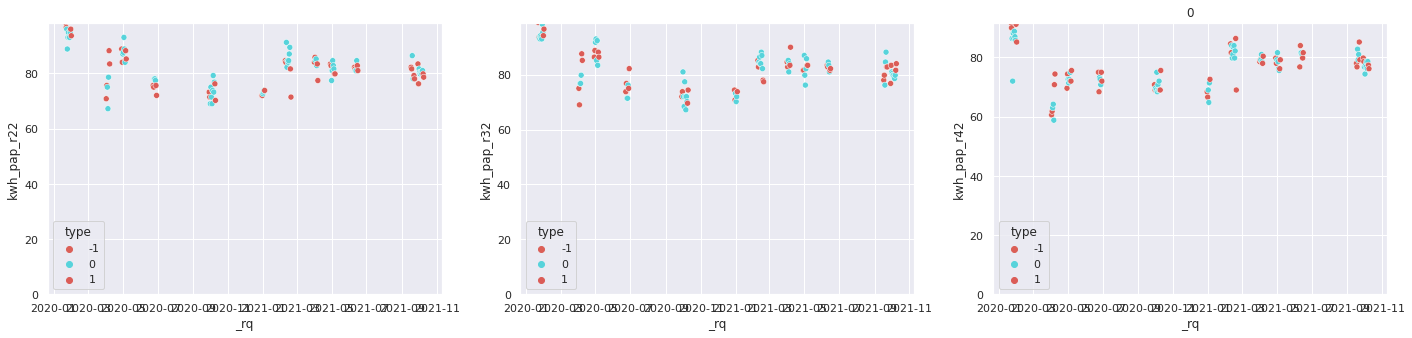

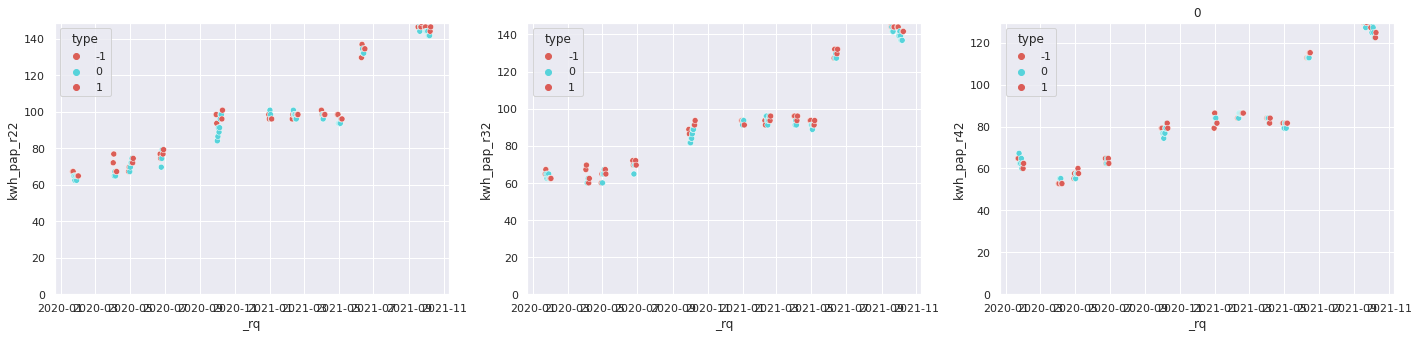

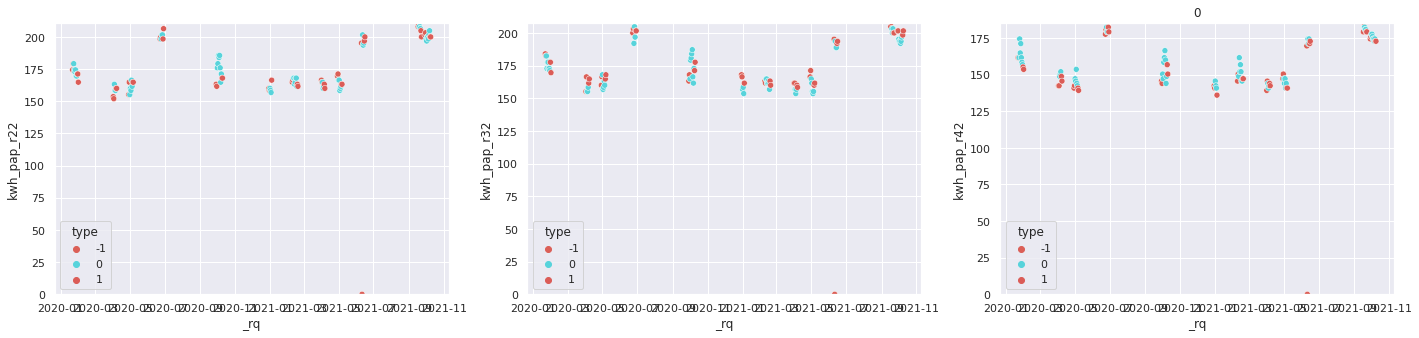

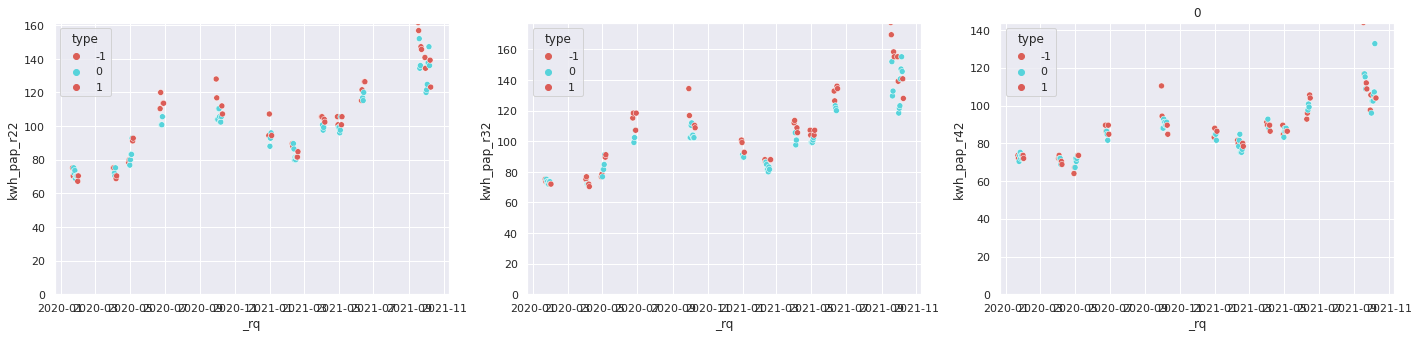

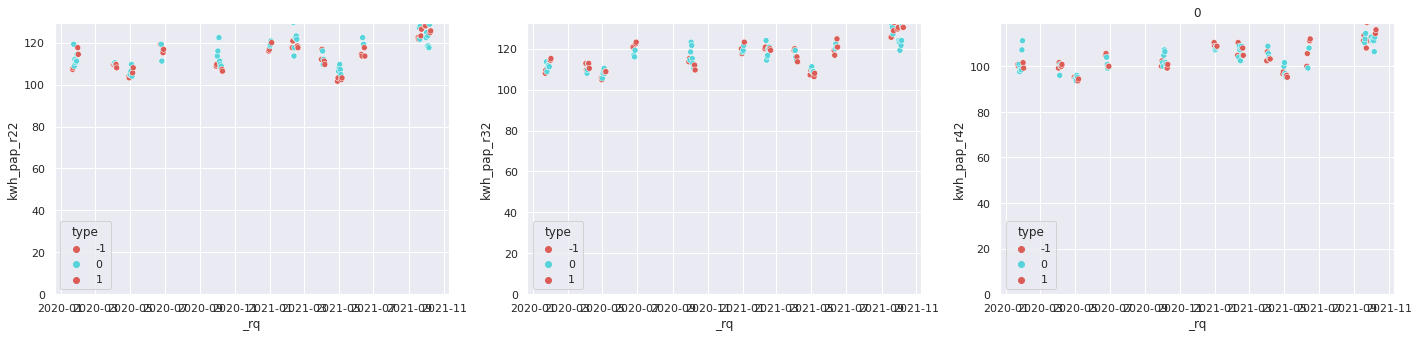

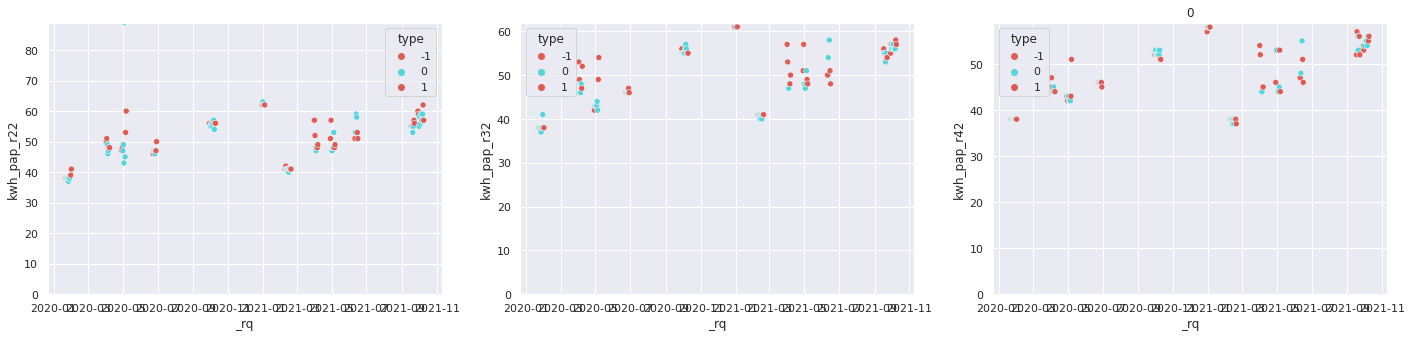

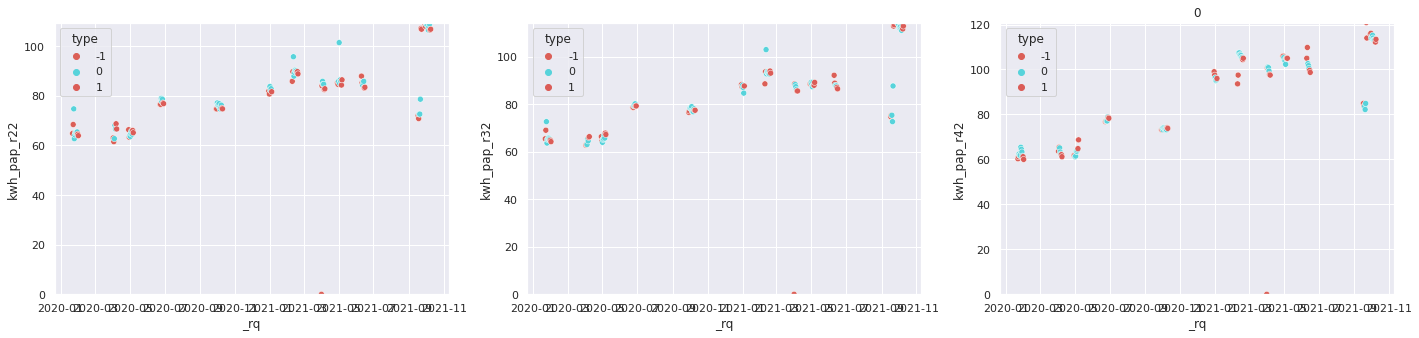

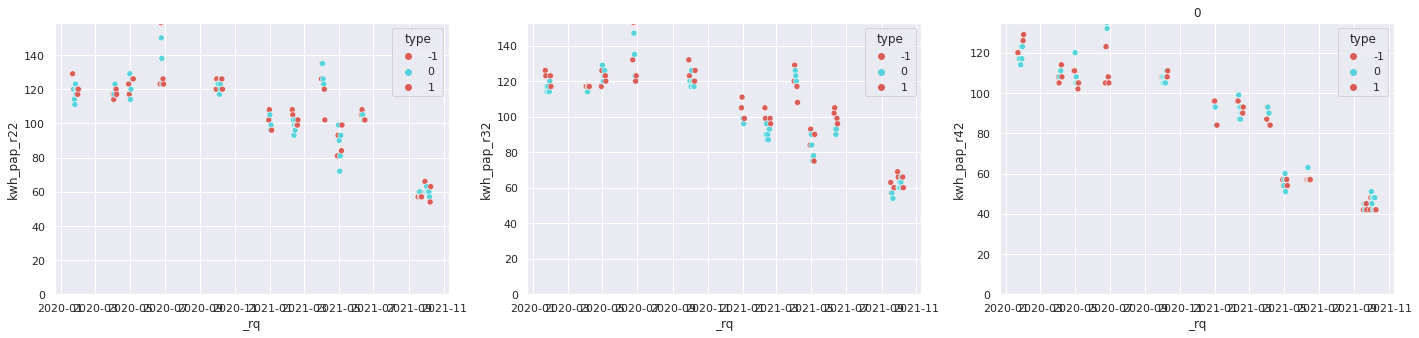

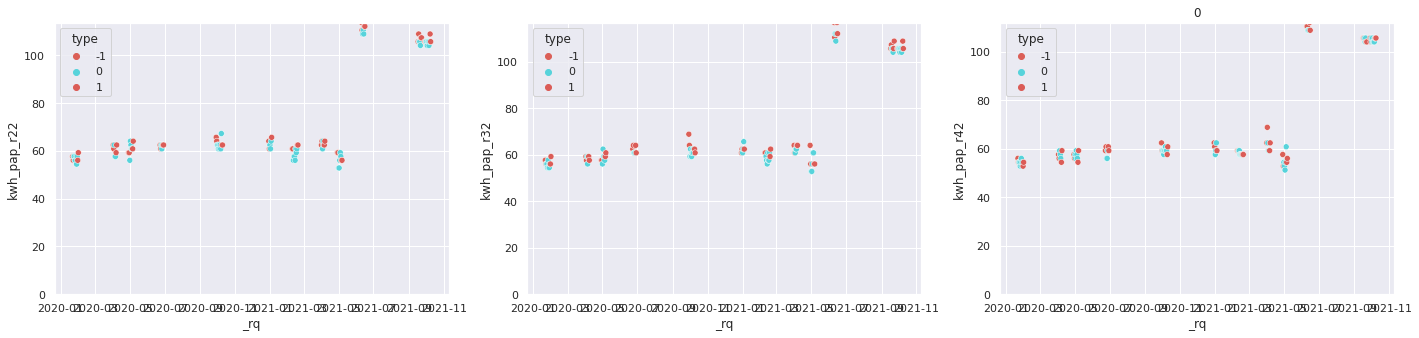

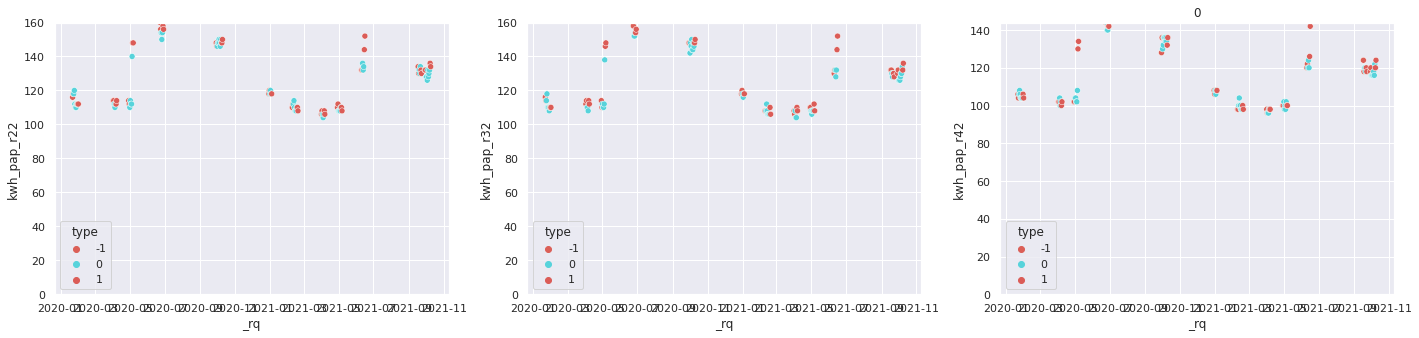

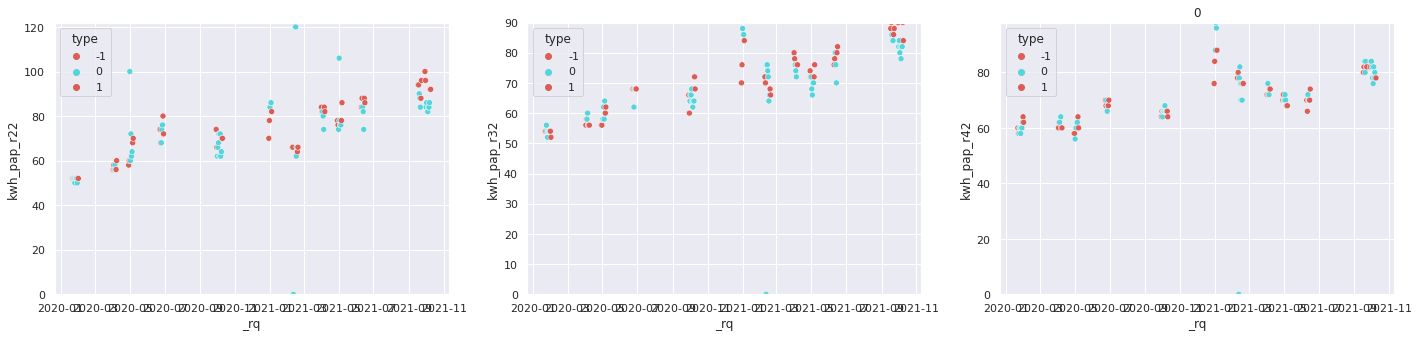

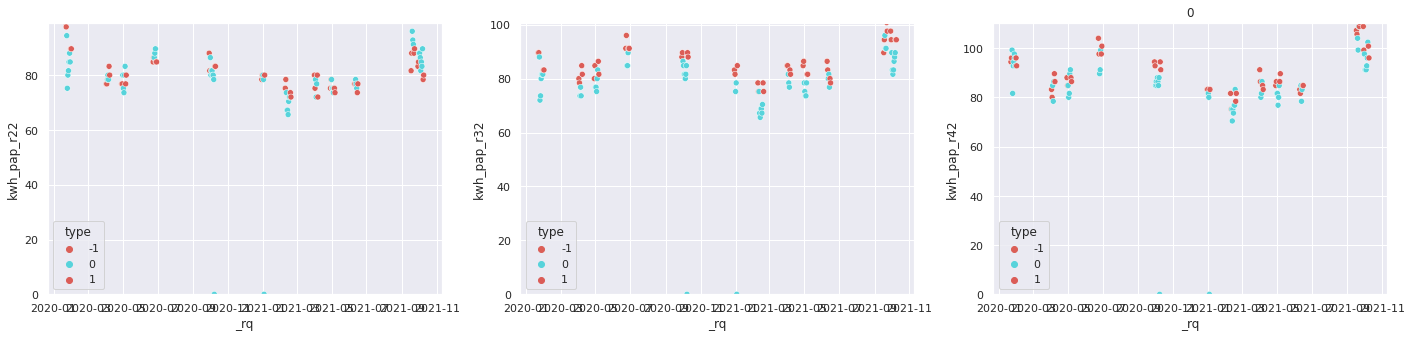

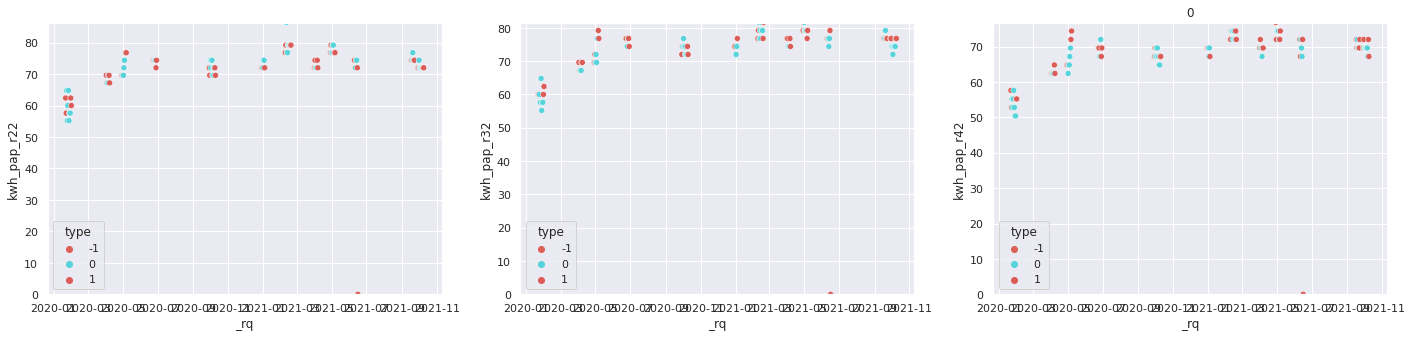

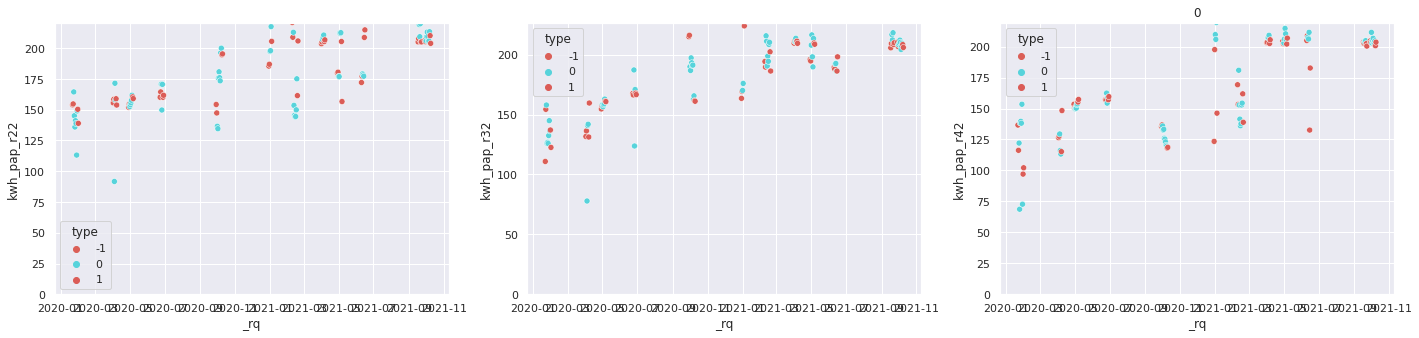

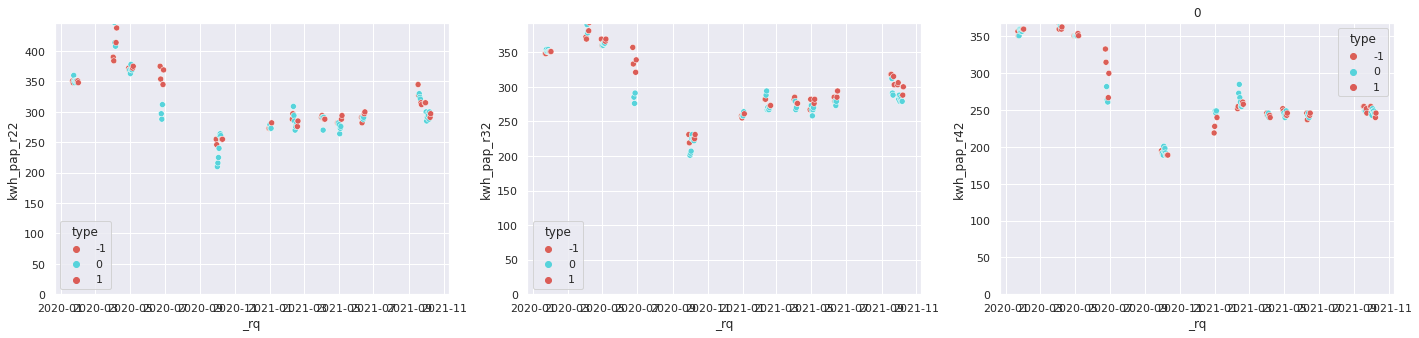

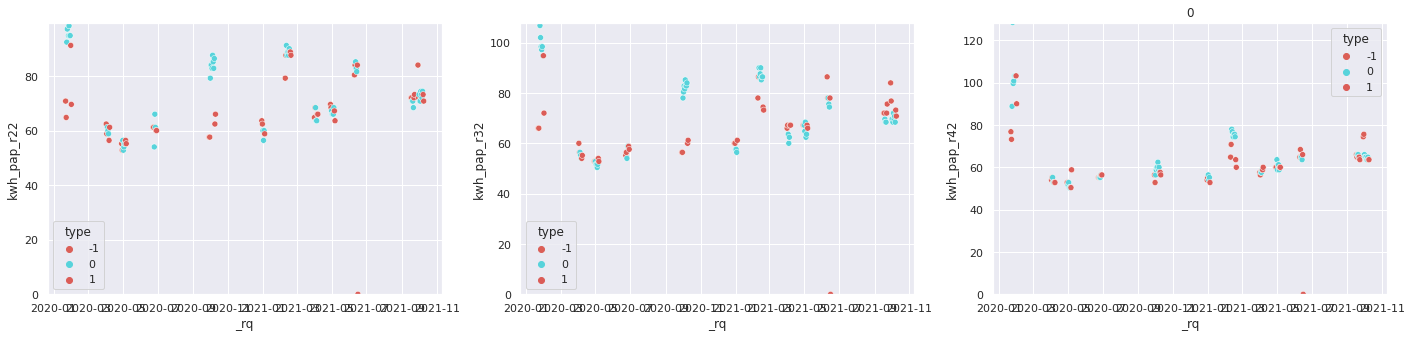

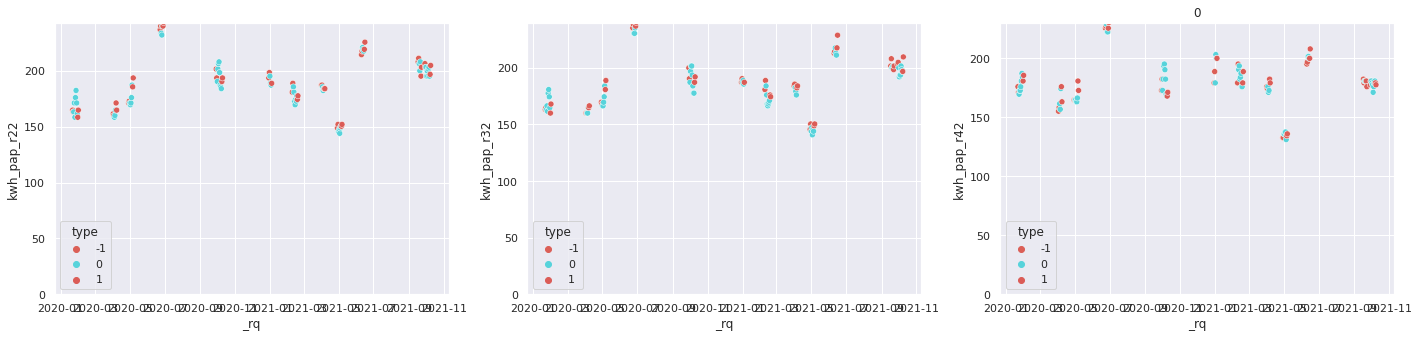

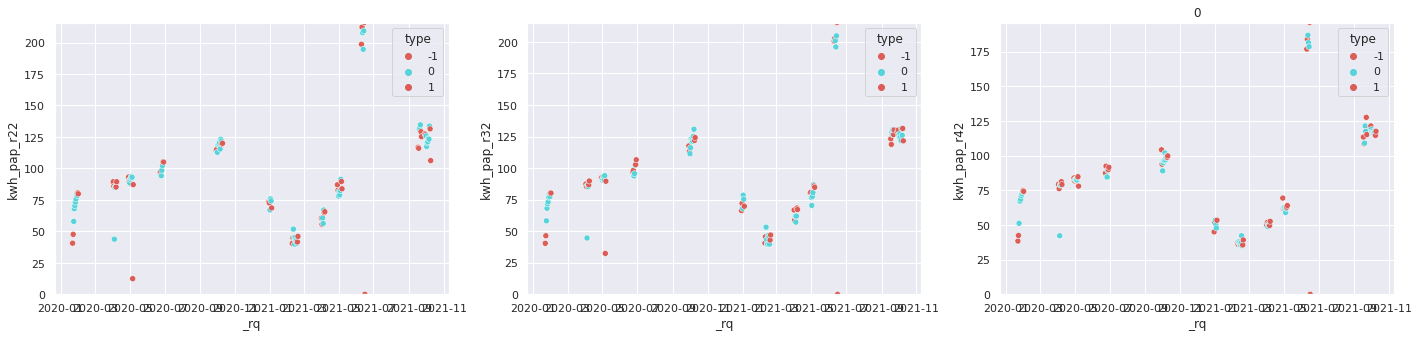

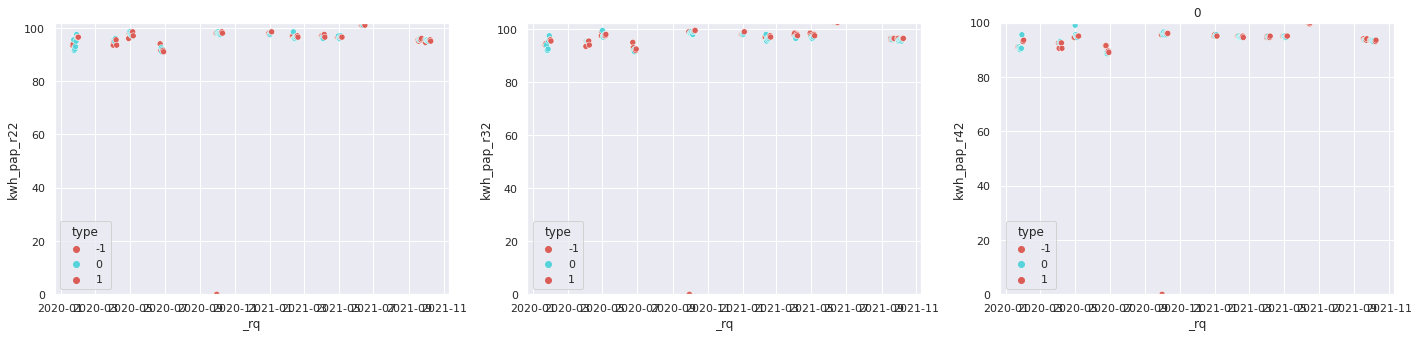

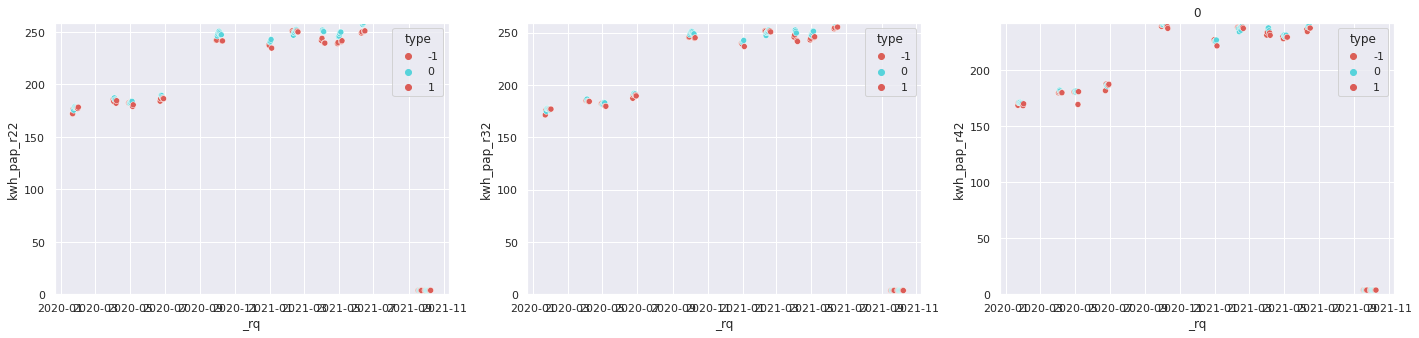

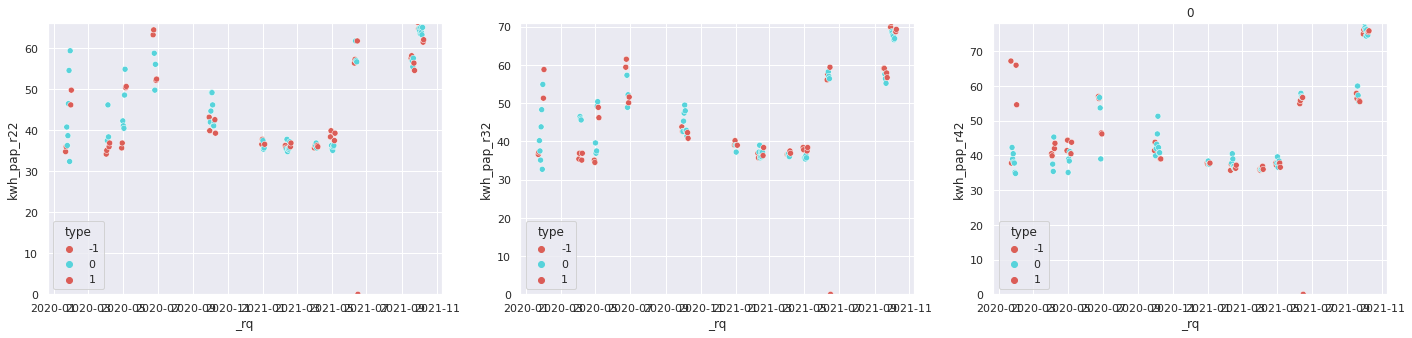

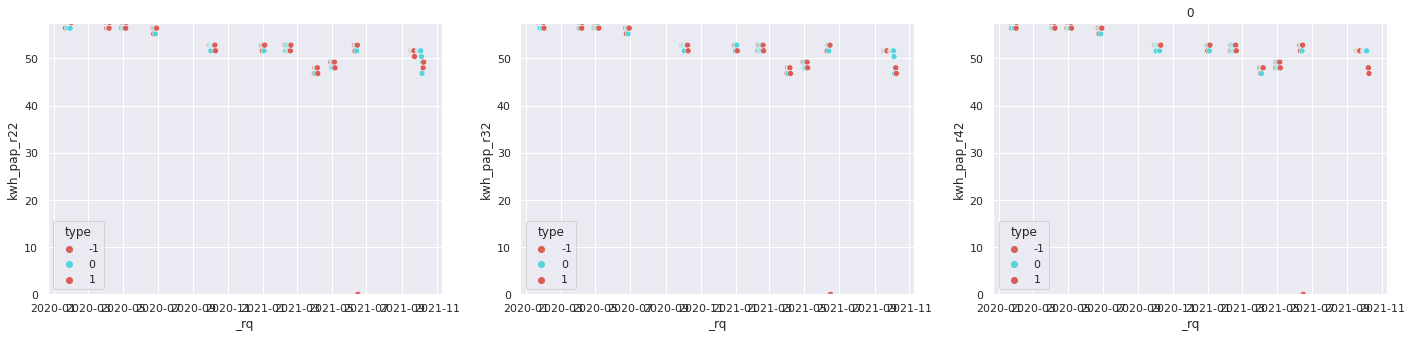

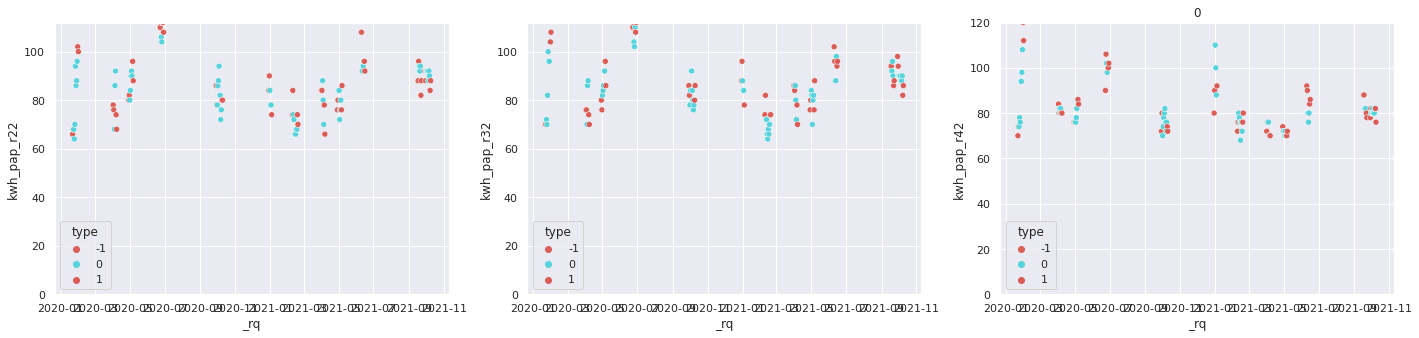

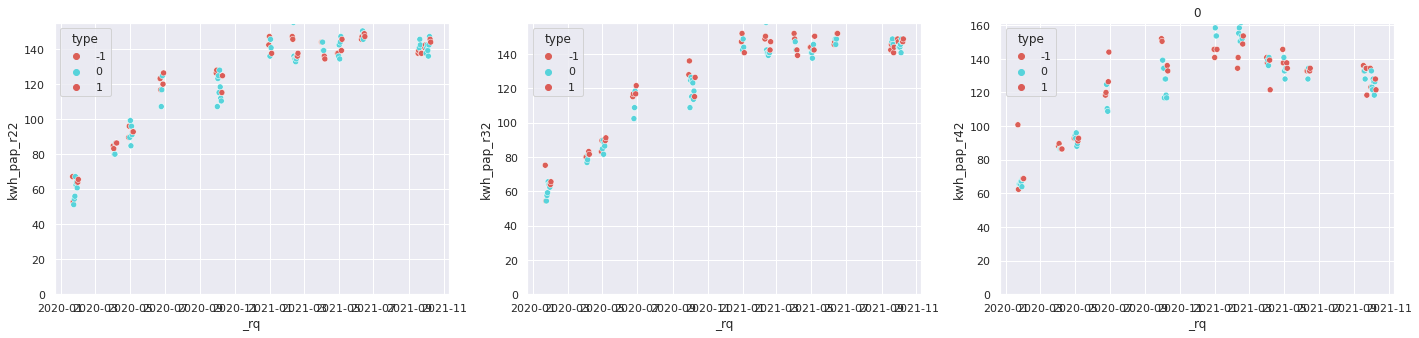

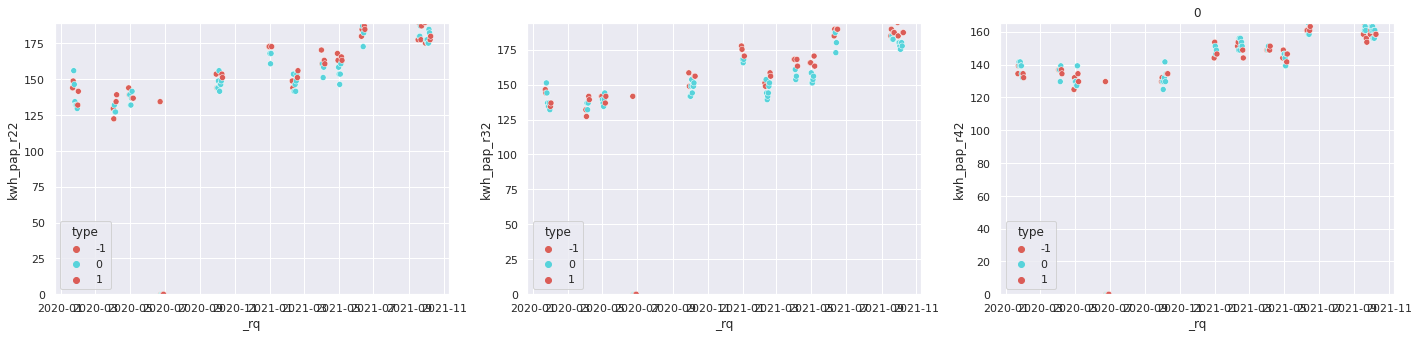

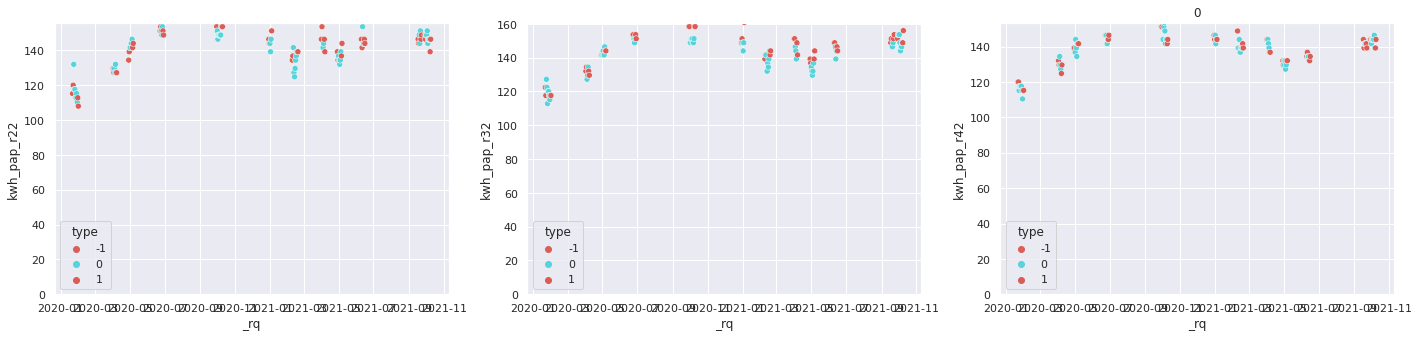

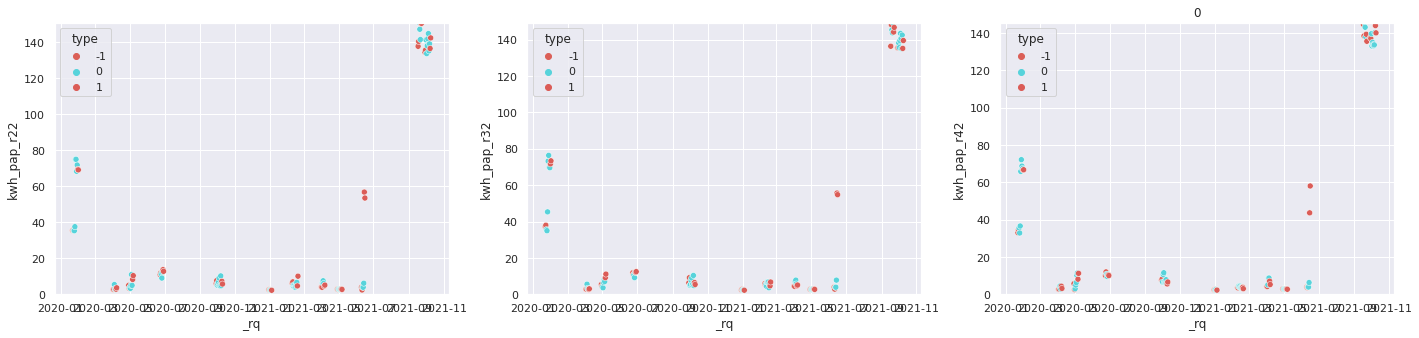

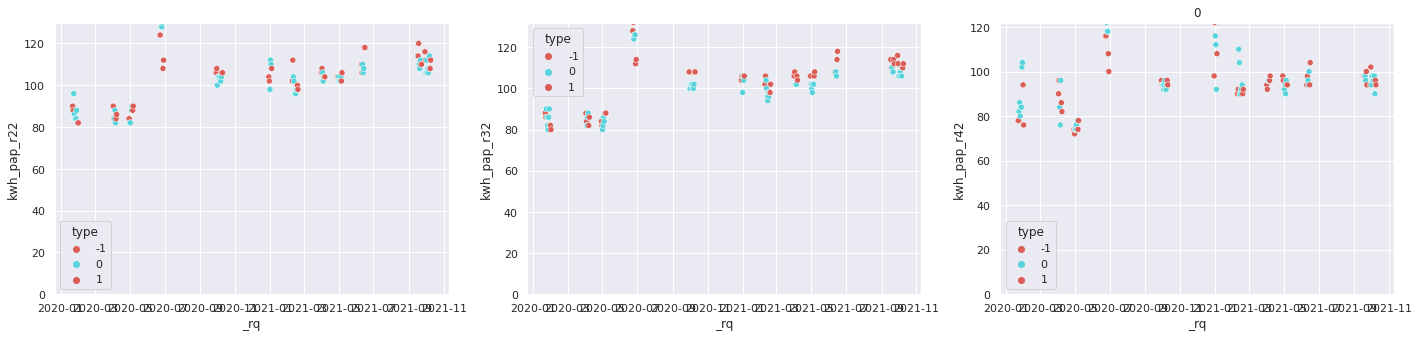

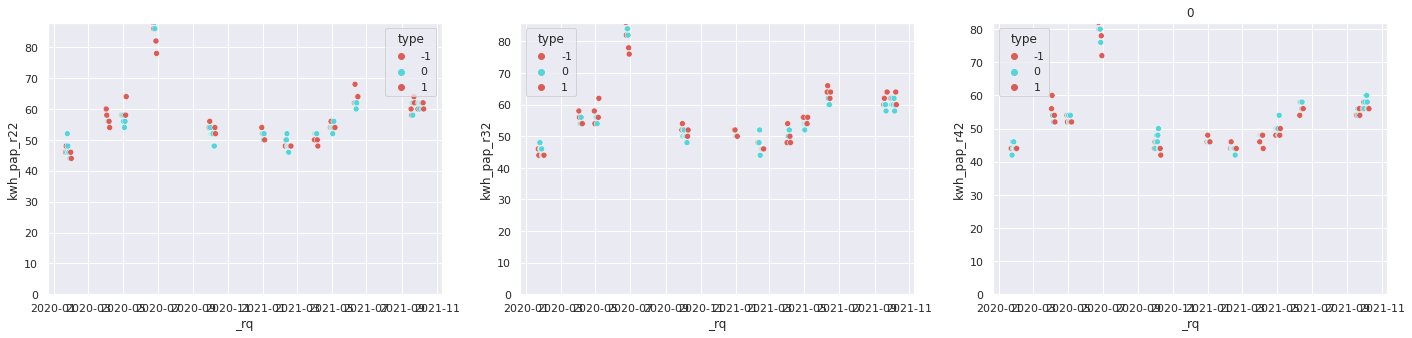

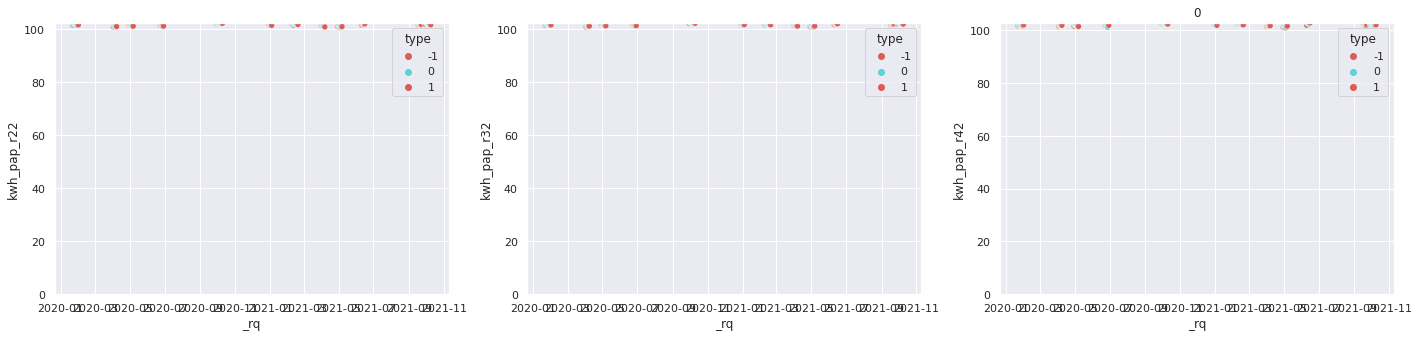

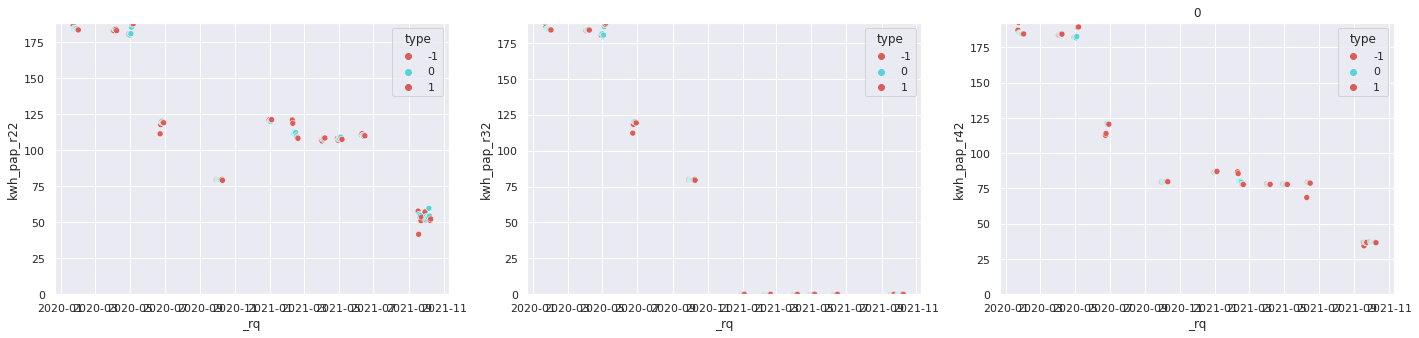

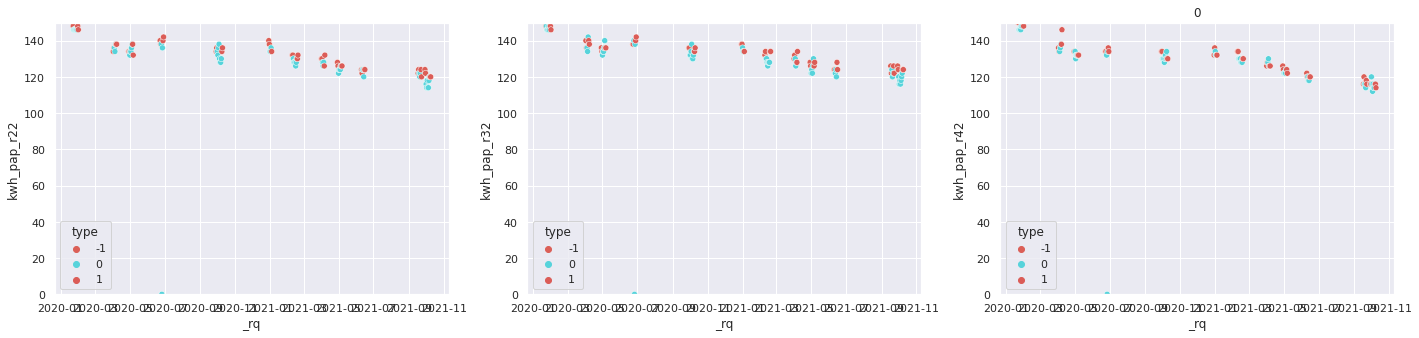

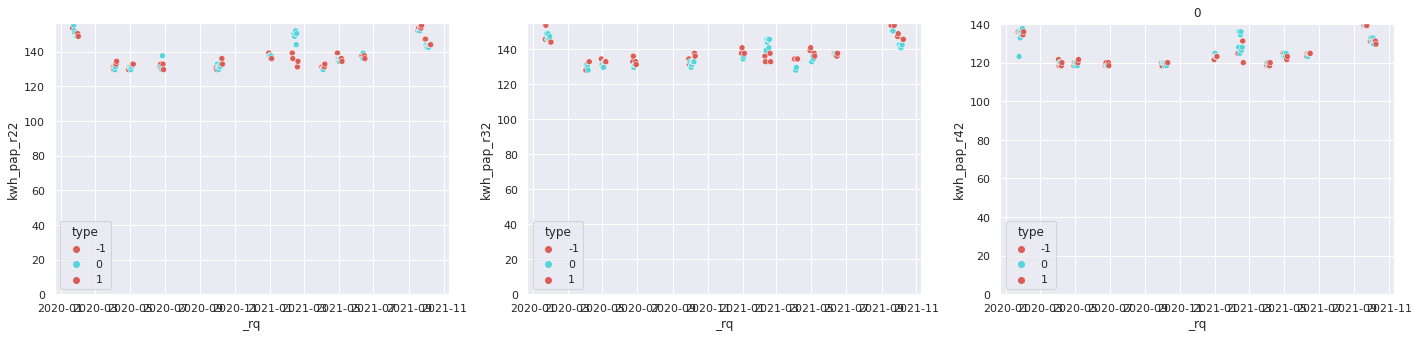

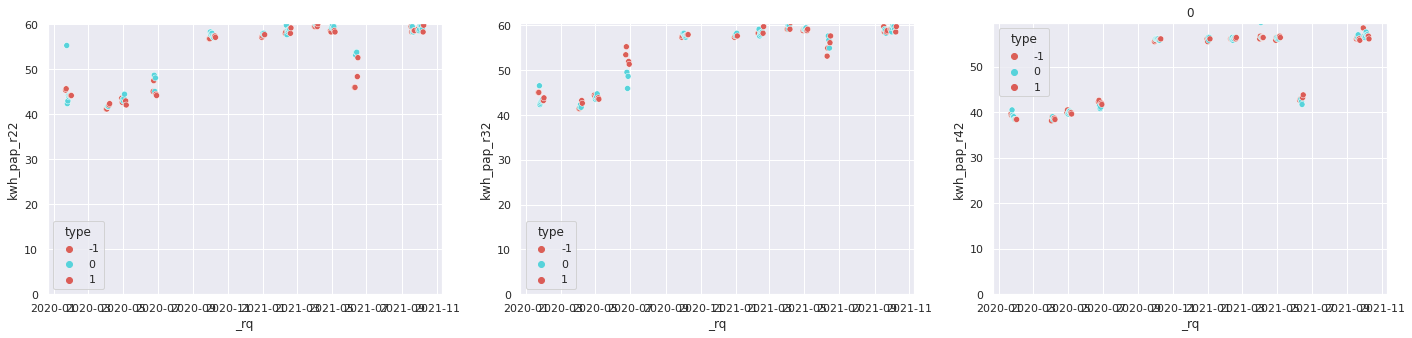

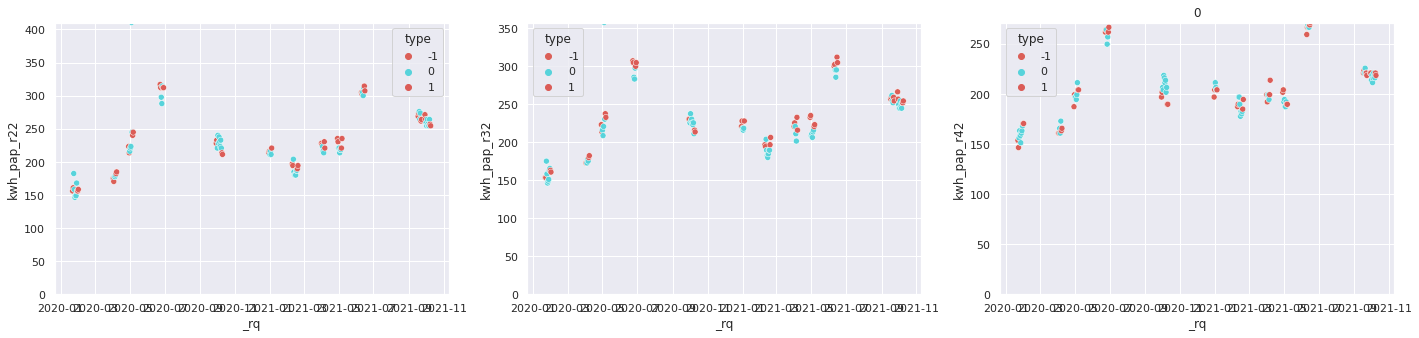

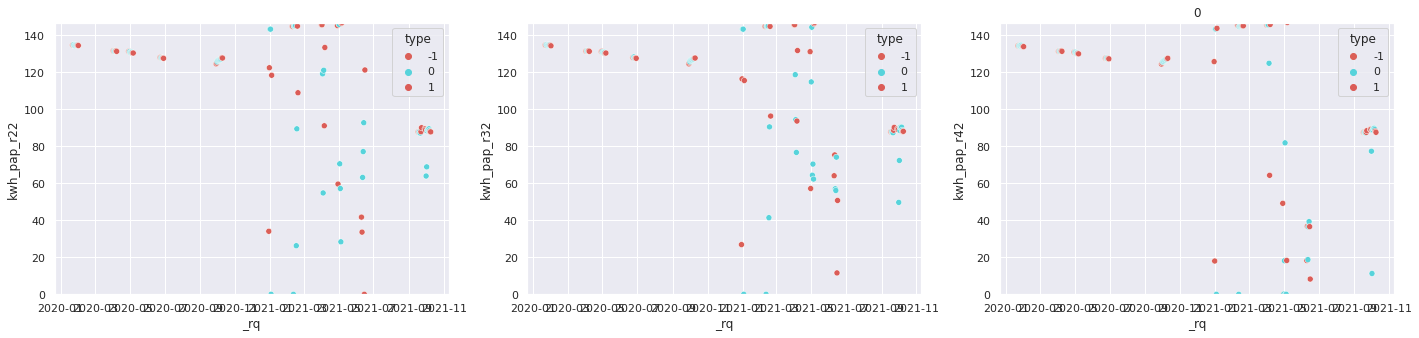

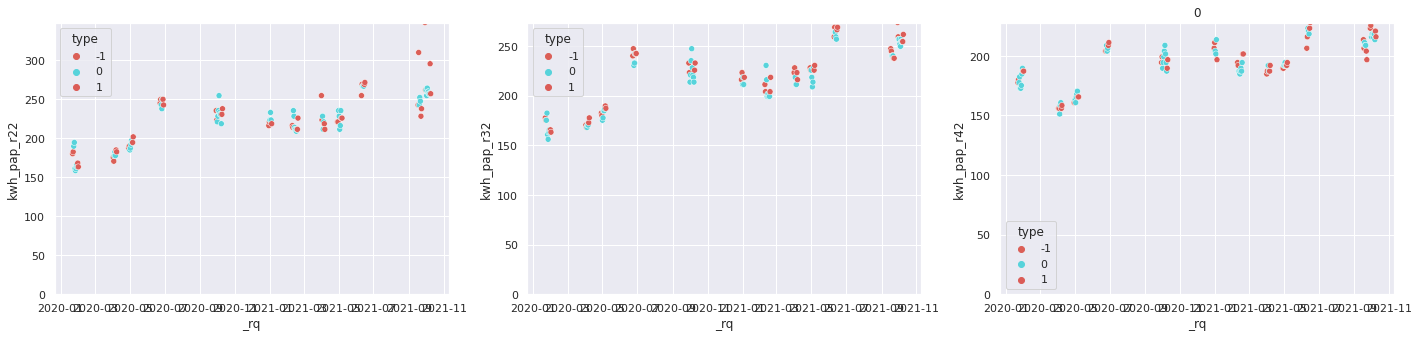

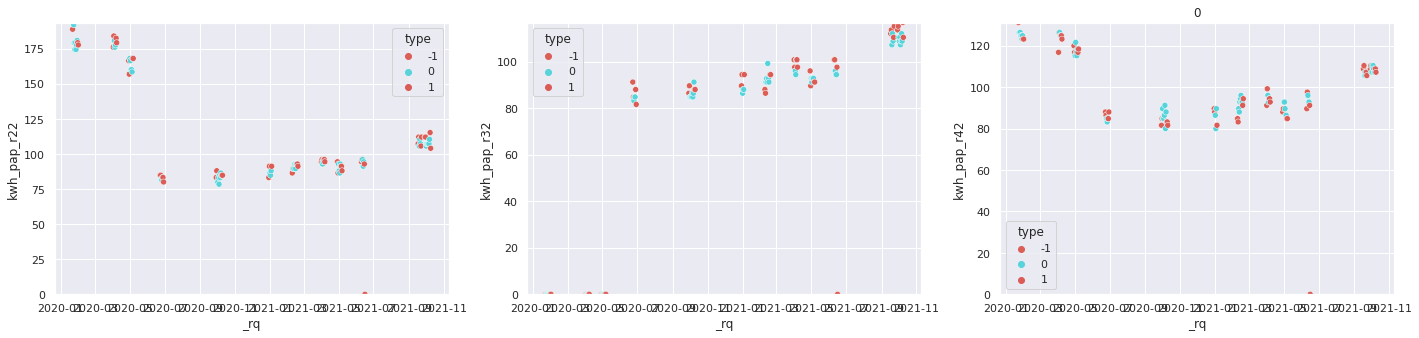

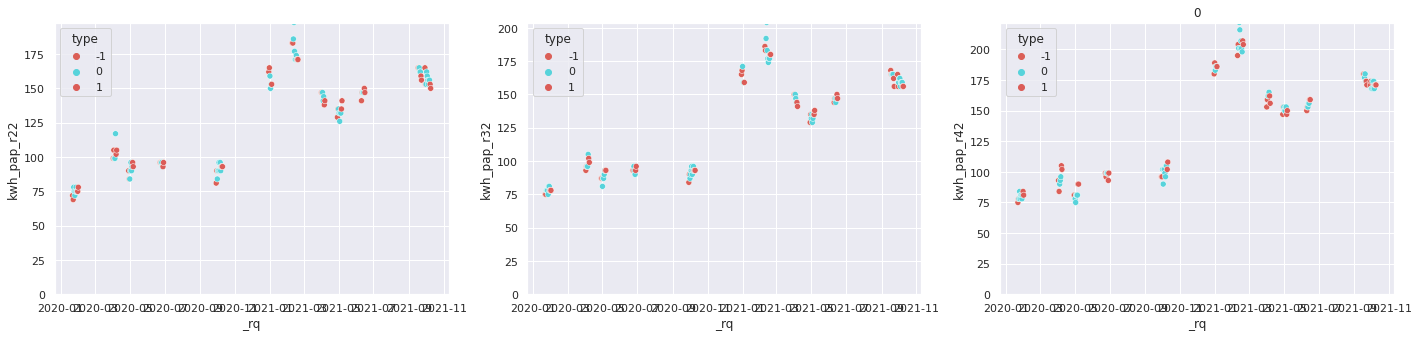

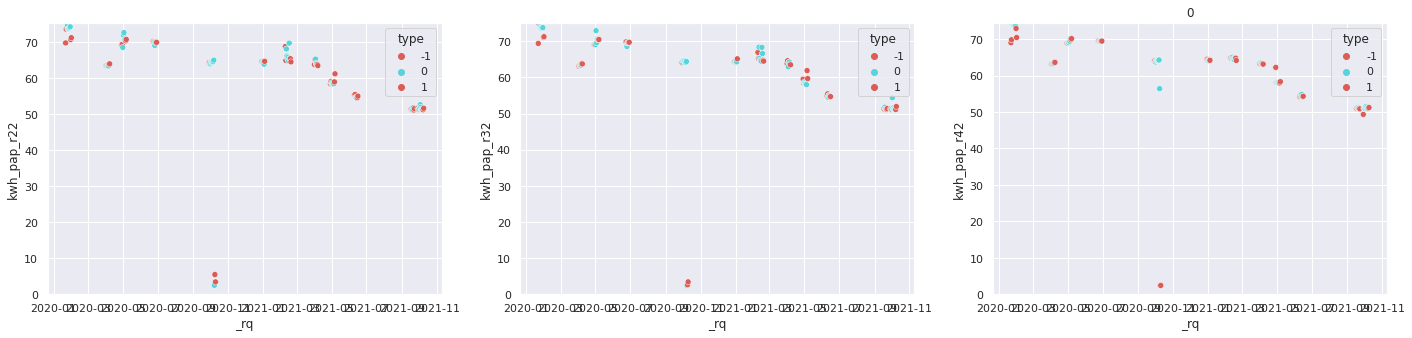

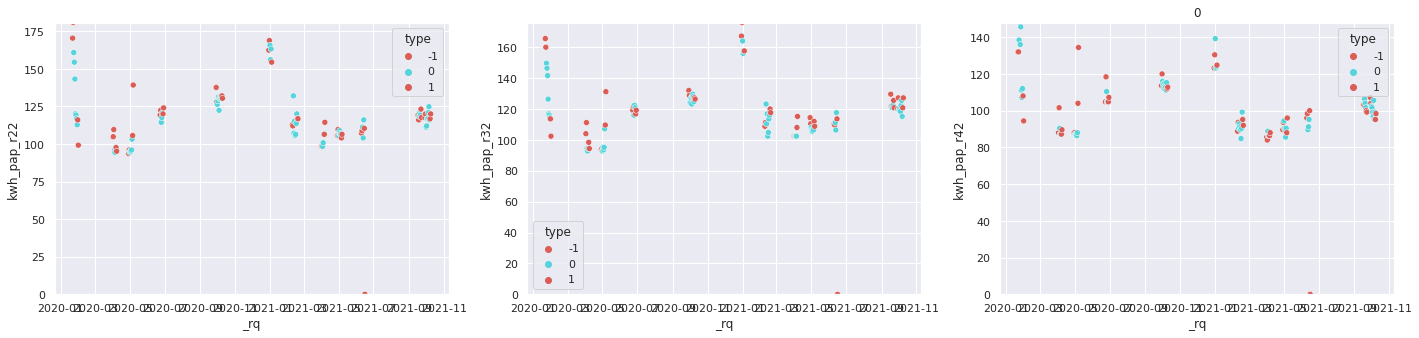

In [523]:
for i in (set(C.minerids) | C.true_ids):
    plt_holiday(i, '0')

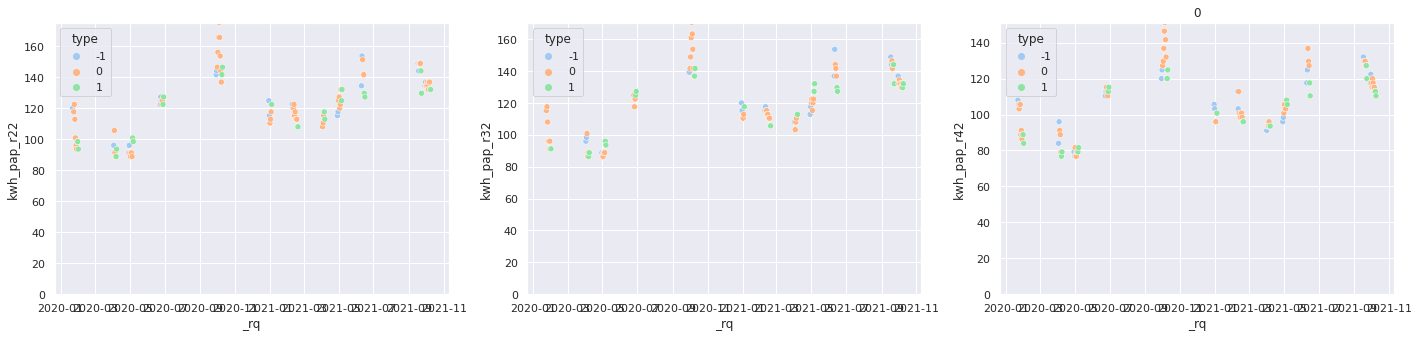

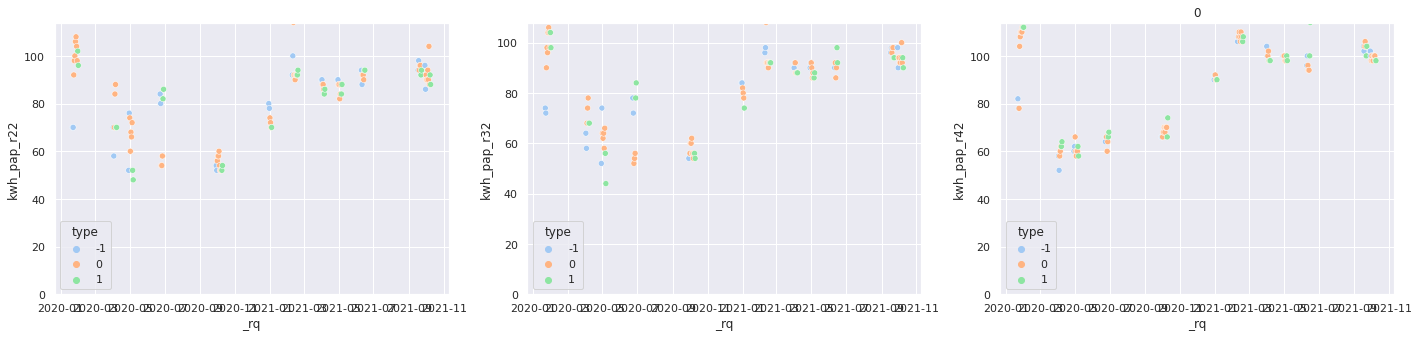

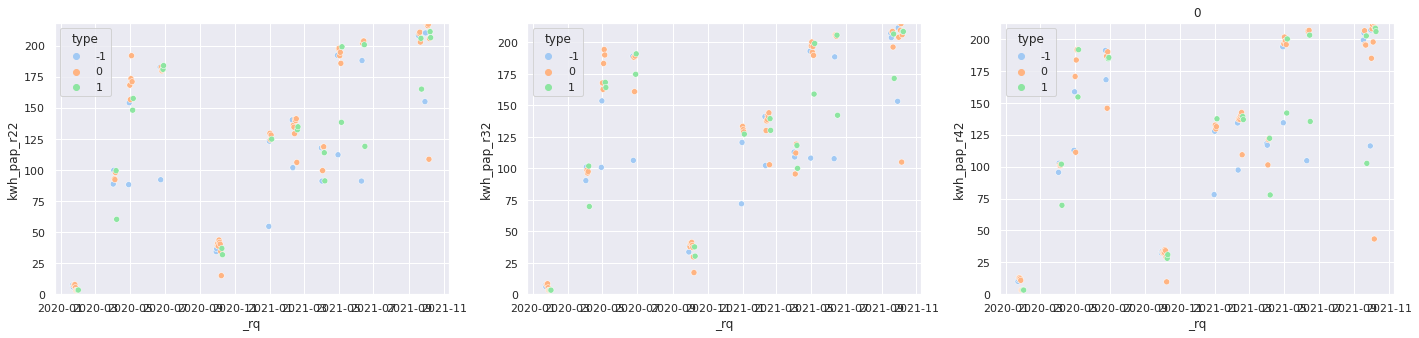

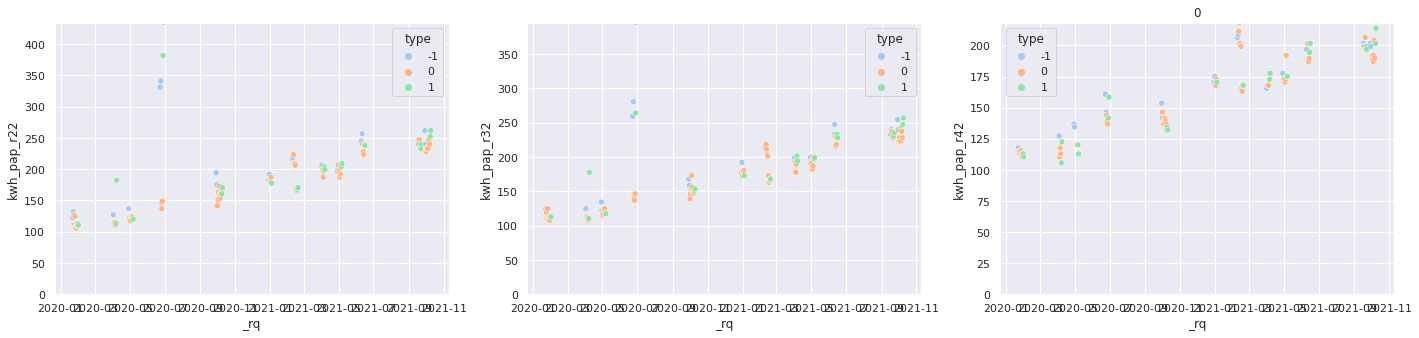

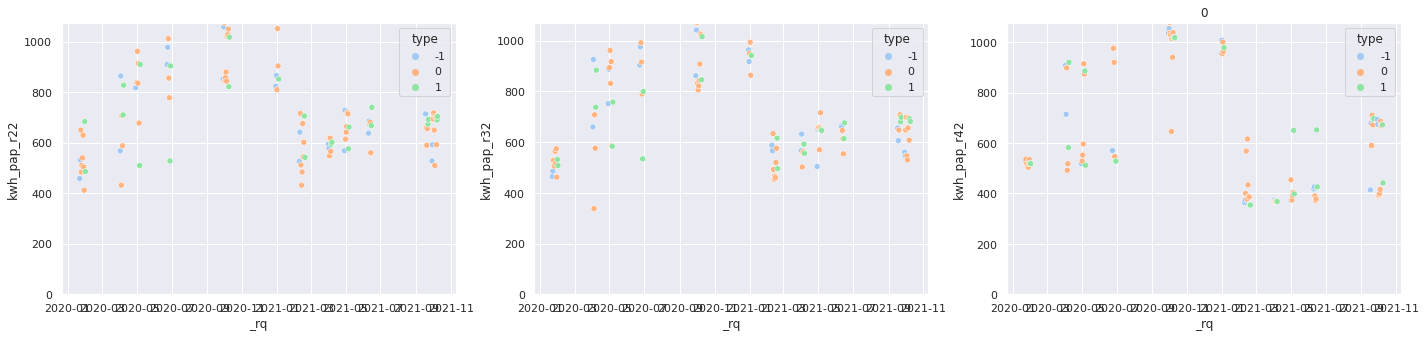

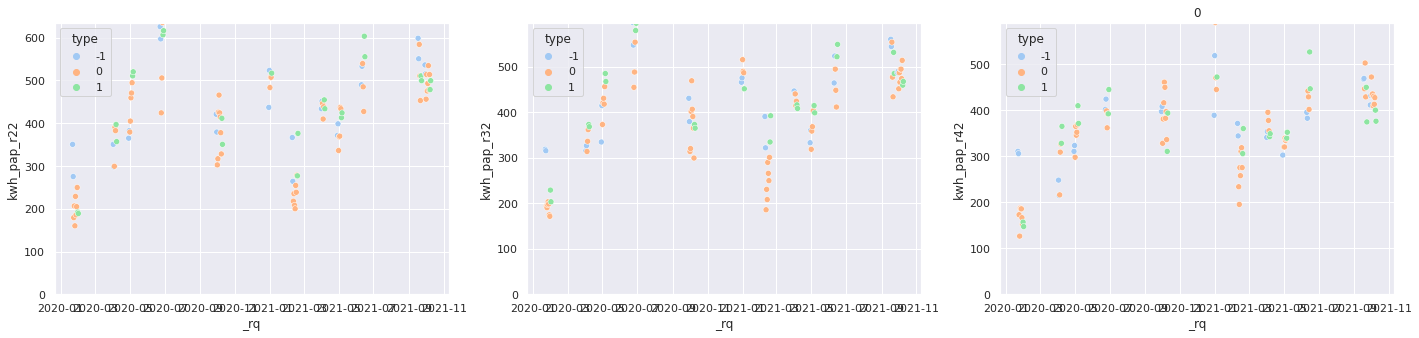

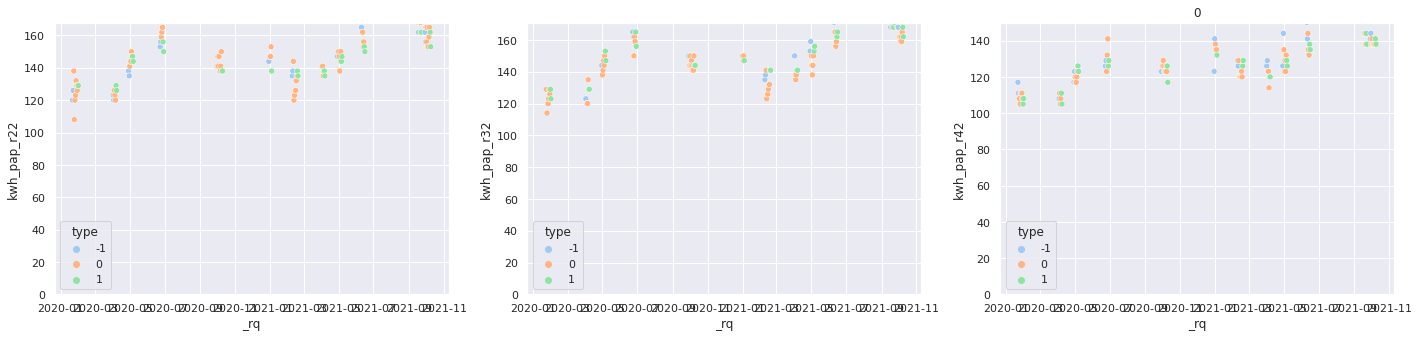

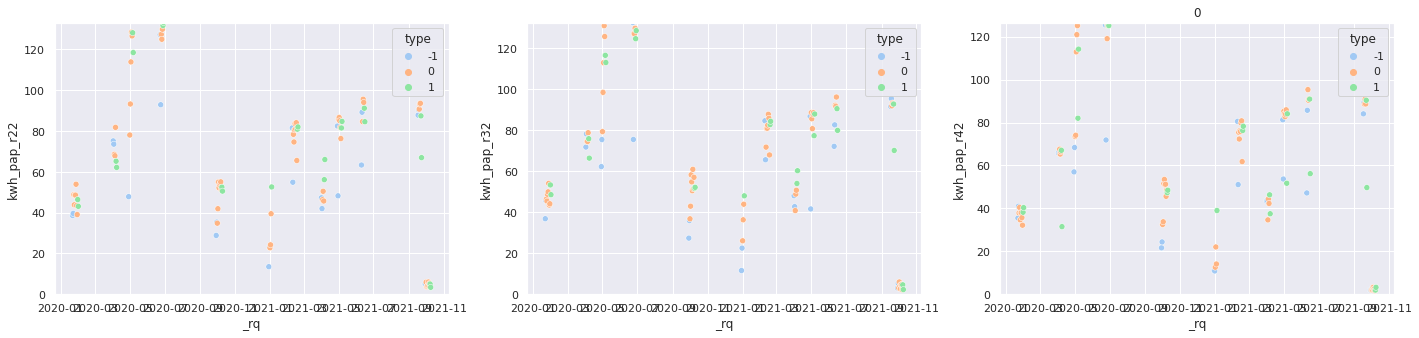

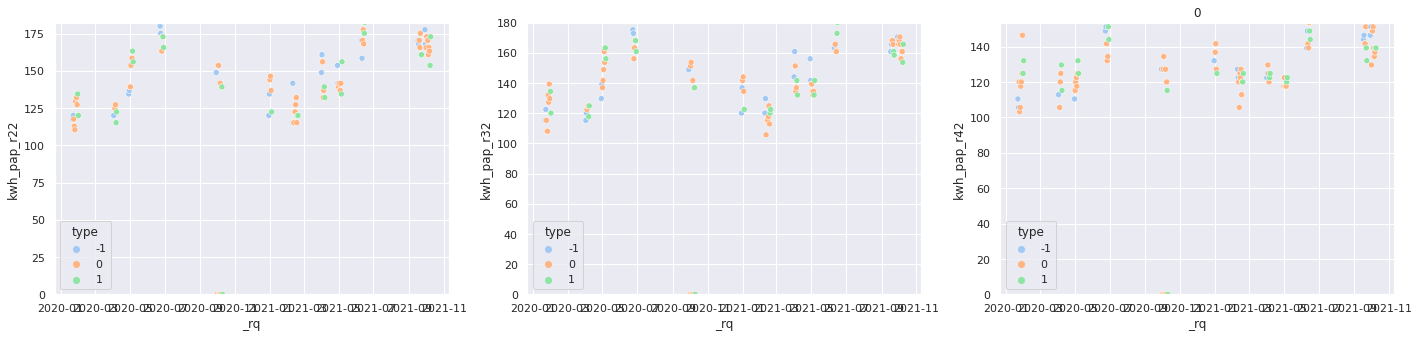

In [522]:
for i in all:
    plt_holiday(i, '0')